In [1]:
import numpy as np
import pandas as pd
import os
import glob
import itertools
import scanpy as sc
import natsort
import json

from scroutines import basicu

import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
from scroutines.config_plots import *

In [3]:
class Bigtensor():
    def __init__(self, bigtensor, meta):
        
        self.palette = {
            'NR': 'C1', 
            'DR': 'k',
            'DL': 'C2', 
        }

        self.anno_marker_dict = {
            'NR': 'o',
            'DR': '^',
            'DL': 'x',
        }
        
        self.anno_alpha_dict = {
            'NR': 1,
            'DR': 0.5,
            'DL': 0.5,
        }
        
        self.anno_markersize_dict = {
            'NR': 3,
            'DR': 10,
            'DL': 10,
        }
        
        self.bigtensor = bigtensor
        self.nf, self.nr, self.nc, self.ng = meta['size']
        self.conds = np.array(meta['dim0'])
        self.reps  = np.array(meta['dim1'])
        self.types = np.array(meta['dim2'])
        self.genes = np.array(meta['dim3'])

        self.conds_time = np.array([int(cond[1:-2]) for cond in self.conds])
        self.conds_anno = np.array([cond[-2:] for cond in self.conds])
        self.conds_color = pd.Series(self.palette).loc[self.conds_anno].values 
        
        return
    
    def plot_one(self, ax, selected_type, selected_gene, annotate=True):
        """
        """
        type_idx = basicu.get_index_from_array(self.types, [selected_type])[0]
        gene_idx = basicu.get_index_from_array(self.genes, [selected_gene])[0]
        
        assert np.all(type_idx != -1)
        assert np.all(gene_idx != -1)

        vals = self.bigtensor[:,:,type_idx, gene_idx] # cond by rep
        vals_mean = np.nanmean(vals, axis=1)


        ax.set_title(f'{selected_gene} in {selected_type}')
        for anno in ['NR', 'DR', 'DL']:
            marker = self.anno_marker_dict[anno]
            sel = self.conds_anno == anno
            if sel.sum() > 0:
                
                if anno == 'NR':
                    ax.set_xticks(self.conds_time[sel])
                    ax.plot(self.conds_time[sel], vals_mean[sel], '-k')

                ax.scatter(np.repeat(self.conds_time[sel], self.nr), vals[sel].reshape(-1,), 
                           color='k',
                           facecolors='none',
                           marker=marker,
                           label=anno,
                          )

        sns.despine(ax=ax)
        ax.grid(axis='x')

        if annotate:
            handles, labels = ax.get_legend_handles_labels()
            unique_labels = dict(zip(labels, handles))
            ax.legend(unique_labels.values(), unique_labels.keys(), fontsize=12) # , bbox_to_anchor=(1,1))

            ax.set_xlabel('Postnatal day (P)')
            ax.set_ylabel('log2(CPM+1)')
        
    def plot_one_simple(self, ax, selected_type, selected_gene, annotate=True, color='k'):
        """
        """
        type_idx = basicu.get_index_from_array(self.types, [selected_type])[0]
        gene_idx = basicu.get_index_from_array(self.genes, [selected_gene])[0]

        assert np.all(type_idx != -1)
        assert np.all(gene_idx != -1)
        
        vals = self.bigtensor[:,:,type_idx, gene_idx] # cond by rep
        vals_mean = np.nanmean(vals, axis=1)


        ax.set_title(f'{selected_gene} in {selected_type}')
        for anno in ['NR', 'DR', 'DL']:
            marker = self.anno_marker_dict[anno]
            sel = self.conds_anno == anno
            if sel.sum() > 0:
                
                if anno == 'NR':
                    ax.plot(self.conds_time[sel], vals_mean[sel], '-', color=color)
                    
                ax.scatter(np.repeat(self.conds_time[sel], self.nr), vals[sel].reshape(-1,), 
                           color=color,
                           facecolors='none',
                           marker=marker,
                           label=anno,
                          )

        sns.despine(ax=ax)

        if annotate:
            handles, labels = ax.get_legend_handles_labels()
            unique_labels = dict(zip(labels, handles))
            ax.legend(unique_labels.values(), unique_labels.keys(), fontsize=12) # , bbox_to_anchor=(1,1))

            ax.set_xlabel('Postnatal day (P)')
            ax.set_ylabel('log2(CPM+1)')
        
    def plot_one_simple_v2(self, ax, selected_type, selected_gene, annotate=True, color='k'):
        """
        """
        type_idx = basicu.get_index_from_array(self.types, [selected_type])[0]
        gene_idx = basicu.get_index_from_array(self.genes, [selected_gene])[0]

        assert np.all(type_idx != -1)
        assert np.all(gene_idx != -1)
        
        vals = self.bigtensor[:,:,type_idx, gene_idx] # cond by rep
        vals_mean = np.nanmean(vals, axis=1)


        ax.set_title(f'{selected_gene} in {selected_type}')
        for anno in ['NR', 'DR', 'DL']:
            marker = self.anno_marker_dict[anno]
            alpha = self.anno_alpha_dict[anno]
            s = self.anno_markersize_dict[anno]
            
            sel = self.conds_anno == anno
            if sel.sum() > 0:
                
                if anno in ['NR', 'DR']:
                    ax.plot(self.conds_time[sel], vals_mean[sel], '-', color=color, alpha=alpha)
                    facecolor=color

                ax.scatter(np.repeat(self.conds_time[sel], self.nr), vals[sel].reshape(-1,), 
                           color=color,
                           s=s,
                           marker=marker,
                           facecolors=facecolor,
                           label=anno,
                           linewidth=1,
                          )

        sns.despine(ax=ax)

        if annotate:
            handles, labels = ax.get_legend_handles_labels()
            unique_labels = dict(zip(labels, handles))
            ax.legend(unique_labels.values(), unique_labels.keys(), fontsize=12) # , bbox_to_anchor=(1,1))

            ax.set_xlabel('Postnatal day (P)')
            ax.set_ylabel('log2(CPM+1)')
        

In [4]:
f_data = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/res/bigtensor_l23type.npy' 
f_meta = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/res/bigtensor_l23type.json' 

bigtensor = np.load(f_data)
with open(f_meta, 'r') as fp:
    meta = json.load(fp)

bo0 = Bigtensor(bigtensor, meta)
print(bigtensor.shape)

(9, 2, 5, 16572)


In [5]:
f_data = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/res/bigtensor_l23type.npy' 
f_meta = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/res/bigtensor_l23type.json' 

bigtensor = np.load(f_data)
with open(f_meta, 'r') as fp:
    meta = json.load(fp)

bo1 = Bigtensor(bigtensor, meta)
print(bigtensor.shape)

(11, 3, 5, 16572)


# plot

In [6]:
def plot_combined(bo0, bo1, gene, types):
    xticks = [6,10,14,17,21,28,38]
    n = len(types)
    
    fig, axs = plt.subplots(1,n,figsize=(n*4,1*4), sharex=True, sharey=True)
    for ax, thistype in zip(axs, types):
        bo0.plot_one_simple(ax, thistype, gene, color='k')
        bo1.plot_one_simple(ax, thistype, gene, annotate=False, color='C1')
        ax.set_xticks(xticks)
        ax.grid(axis='x')

    plt.show()
    
def plot_combined_v2(bo0, bo1, gene, types):
    n = 2
    # n = len(types)
    
    fig, axs = plt.subplots(1,n,figsize=(n*4,1*4), sharey=True)
    for ax, bo in zip(axs, [bo0, bo1]): 
        for i, thistype in enumerate(types):
            annotate = False
            bo.plot_one_simple_v2(ax, thistype, gene, annotate=annotate, color=f'C{i}')
        ax.grid(axis='x')
    axs[0].set_xlabel('Postnatal day (P)')
    axs[0].set_ylabel('log2(CPM+1)')
    axs[0].set_title(f'{gene} in Cheng22')
    xticks = [6,10,14,17,21,28,38]
    axs[0].set_xticks(xticks)
    
    axs[1].set_title(f'{gene} in multiome')
    xticks = [6,10,14,17,21]
    axs[1].set_xticks(xticks)
    plt.show()
    
def plot_single(bo, genes, types):
    n = len(genes)
    
    fig, axs = plt.subplots(1,n,figsize=(n*4,1*4), sharey=False)
    for j, ax in enumerate(axs):
        gene = genes[j]
        for i, thistype in enumerate(types):
            annotate = False
            bo.plot_one_simple_v2(ax, thistype, gene, annotate=annotate, color=f'C{i}')
            ax.set_title(f'{gene}')
        xticks = [6,10,14,17,21]
        ax.set_xticks(xticks)
        ax.grid(axis='x')
        
    axs[0].set_xlabel('Postnatal day (P)')
    axs[0].set_ylabel('log2(CPM+1)')
    plt.show()

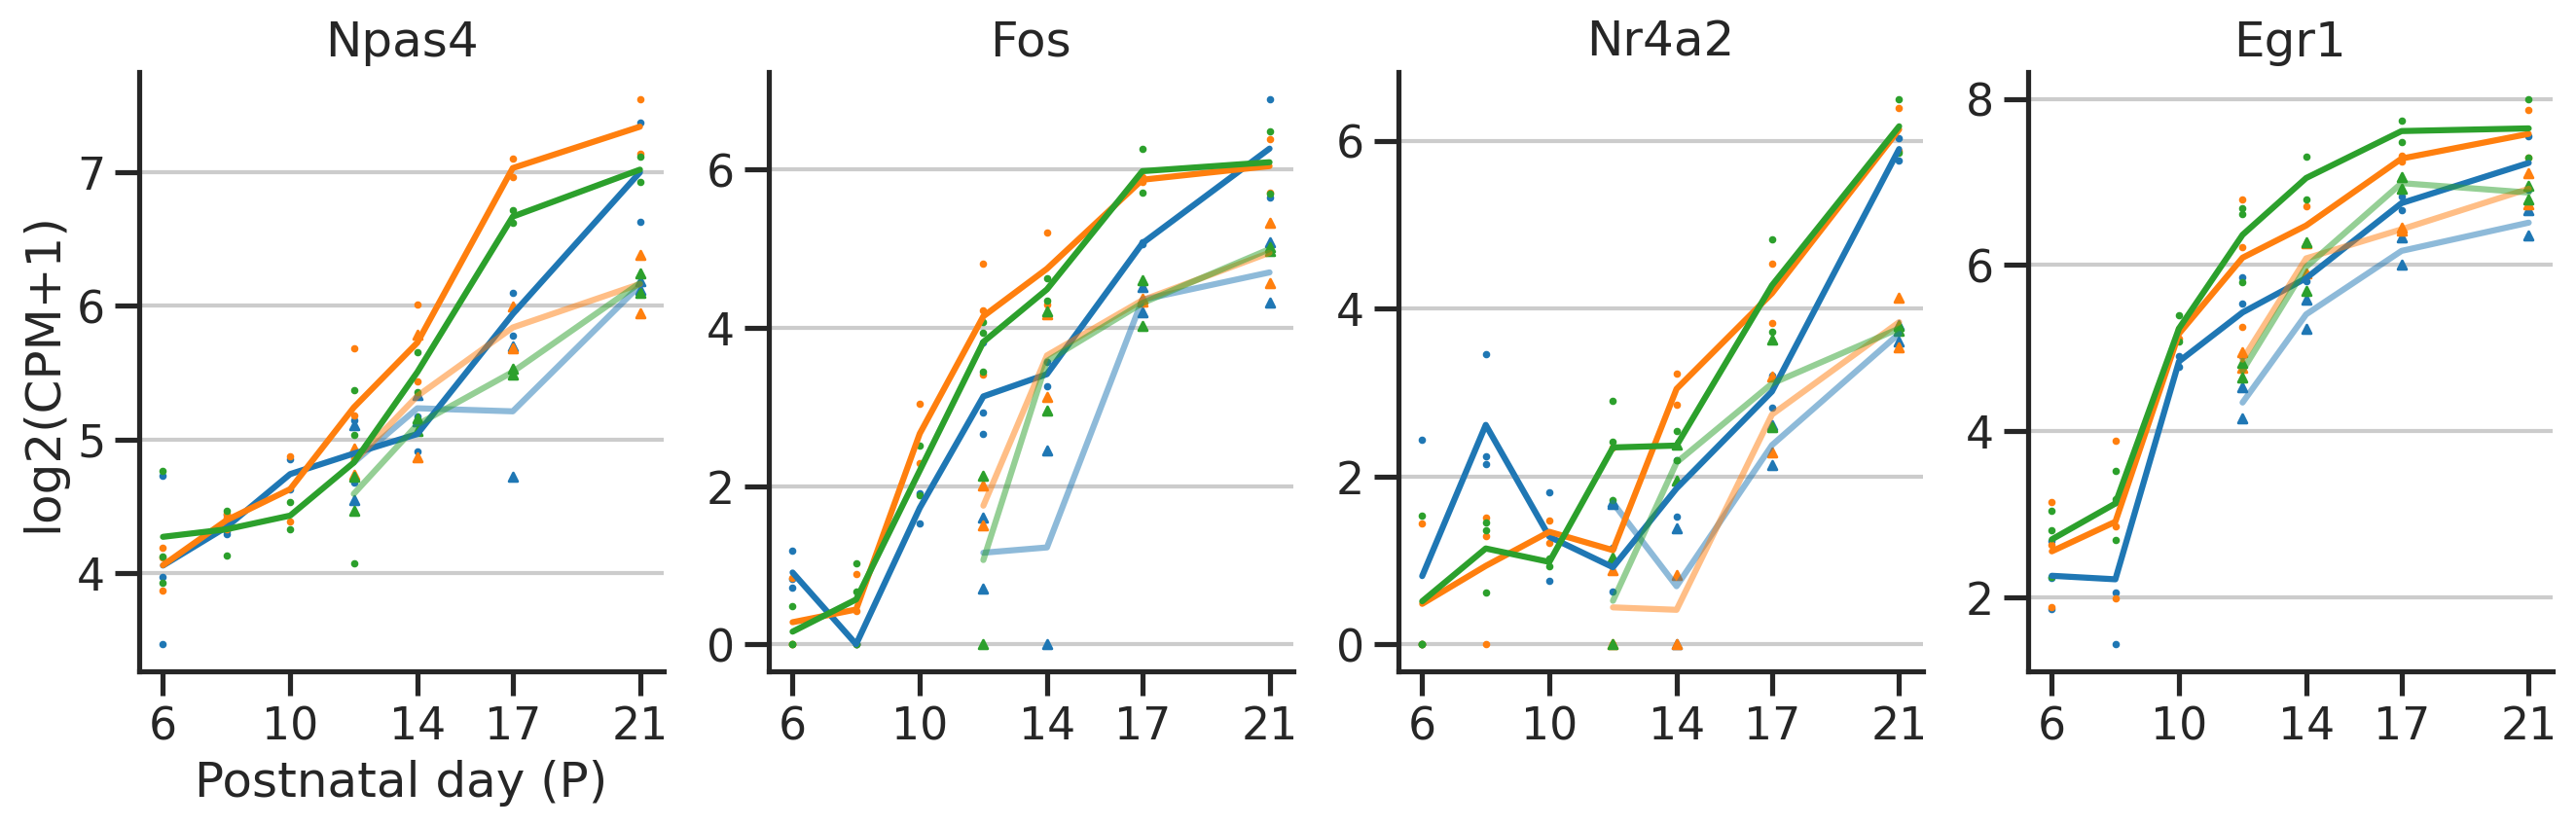

In [7]:
plot_single(bo1, [
    'Npas4', 'Fos', 'Nr4a2', 'Egr1',
     ], 
    ['A', 'B', 'C'])

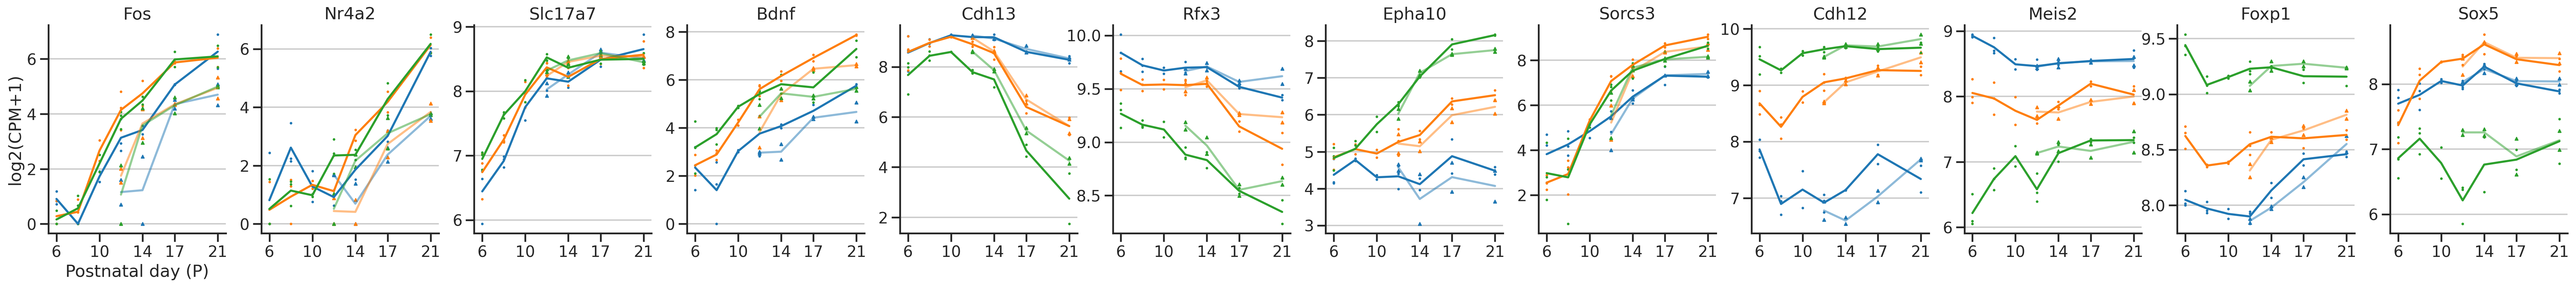

In [8]:
plot_single(bo1, [
    'Fos', 'Nr4a2', 'Slc17a7',
    'Bdnf',
    'Cdh13', 'Rfx3',
    'Epha10', 'Sorcs3',
    'Cdh12', 
    'Meis2', 'Foxp1', 'Sox5',
     ], 
    ['A', 'B', 'C'])

In [18]:
genes_b5 = ['Tnfaip6', 'C1ql3', 'Btg2', 'Mapk4', 'Npas4', 'Bdnf', 'Pde10a',
        'Syt7', 'Kcnip3', 'Nptx2', 'Phf21b', 'Me3', 'Rapgef5', 'Megf11',
        'Trpc6', 'Gria4', '1700016P03Rik', 'Cacna2d3', 'Sorcs3', 'Ppm1h',
        'Shc3', 'Homer1', 'Dgkb', 'Ifrd1', 'Baz1a', '9630002D21Rik',
        'Ppme1', 'Zbtb16', 'Arnt2', 'Wdr17']
print(len(genes_b5))

30


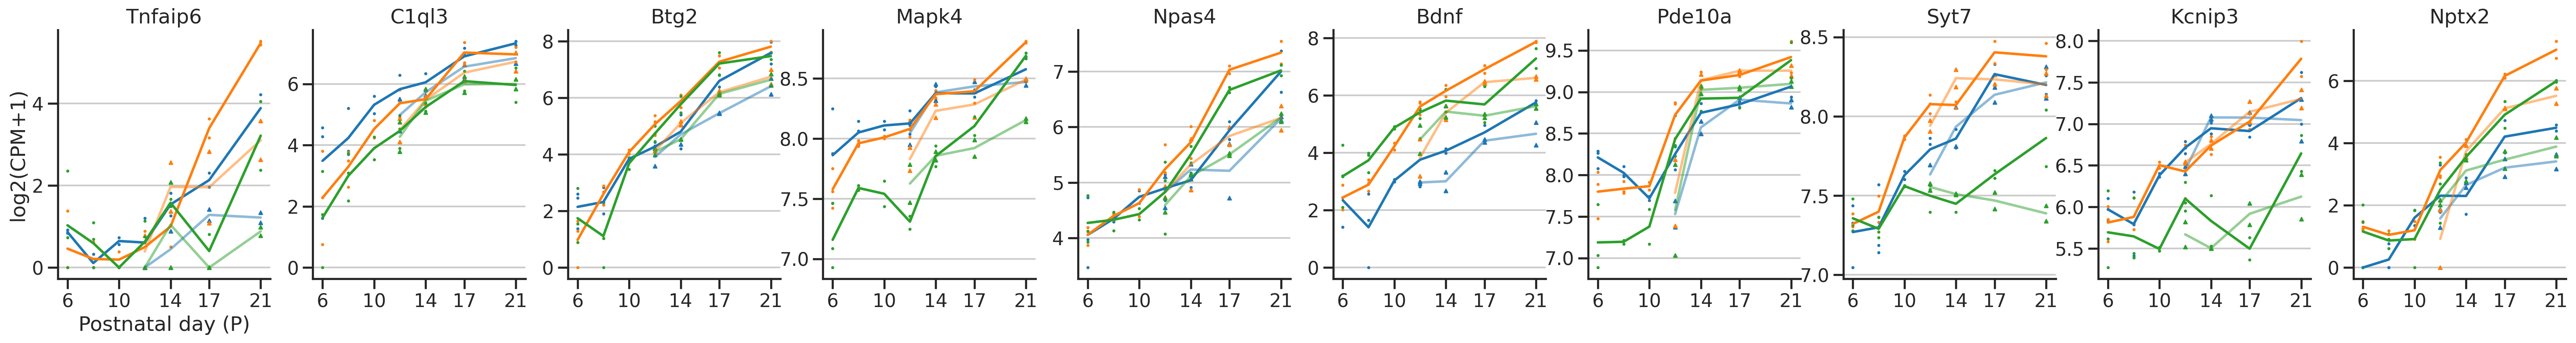

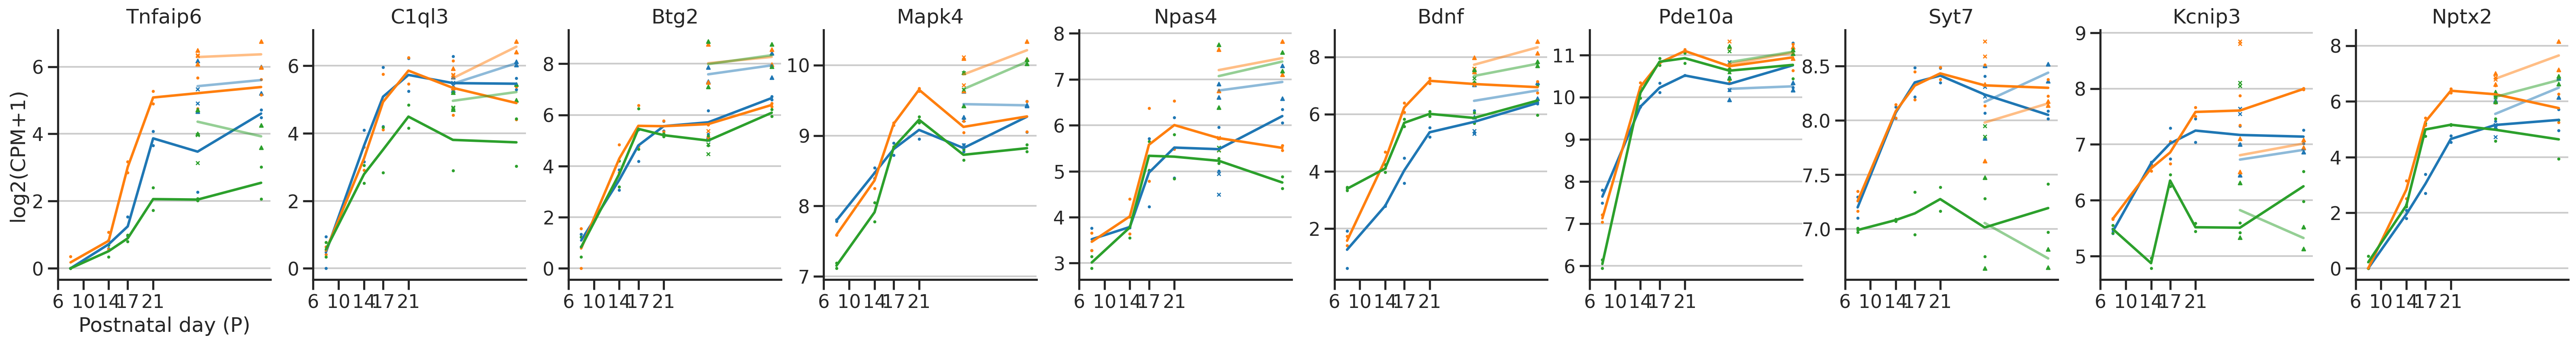

In [19]:
plot_single(bo1, genes_b5[:10],
    ['A', 'B', 'C'])
plot_single(bo0, genes_b5[:10],
    ['A', 'B', 'C'])

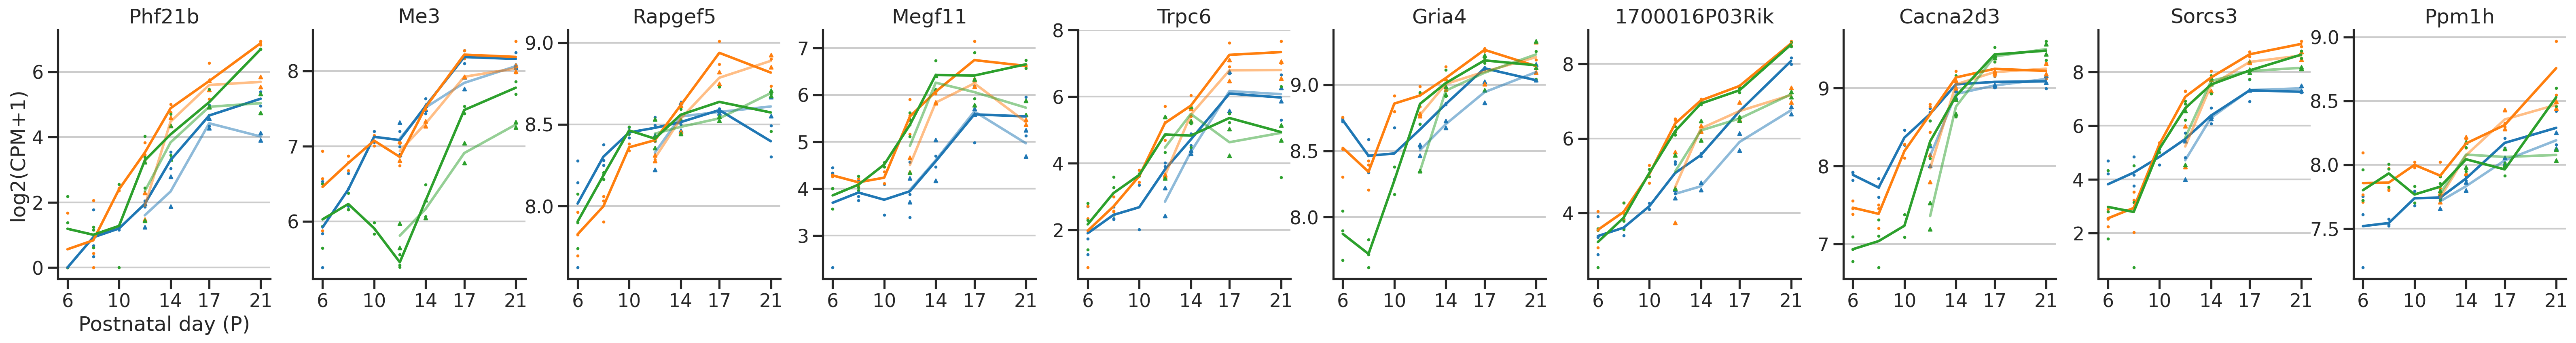

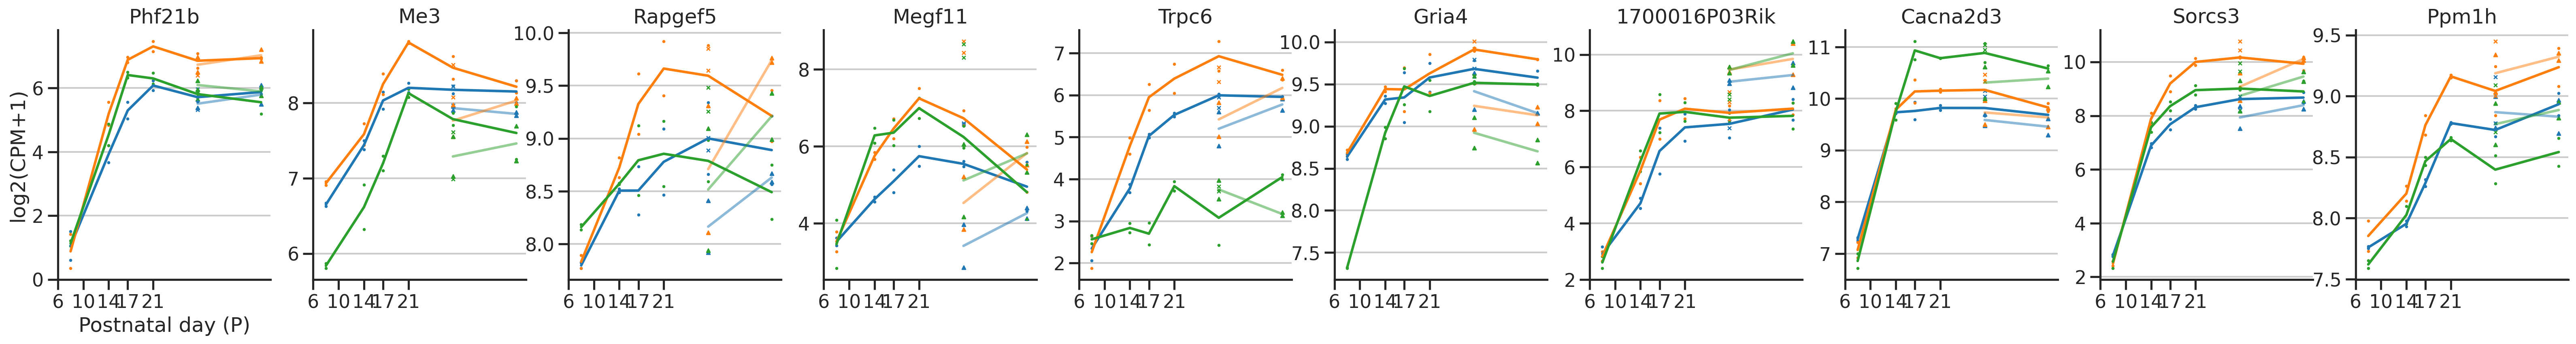

In [20]:
plot_single(bo1, genes_b5[10:20],
    ['A', 'B', 'C'])
plot_single(bo0, genes_b5[10:20],
    ['A', 'B', 'C'])

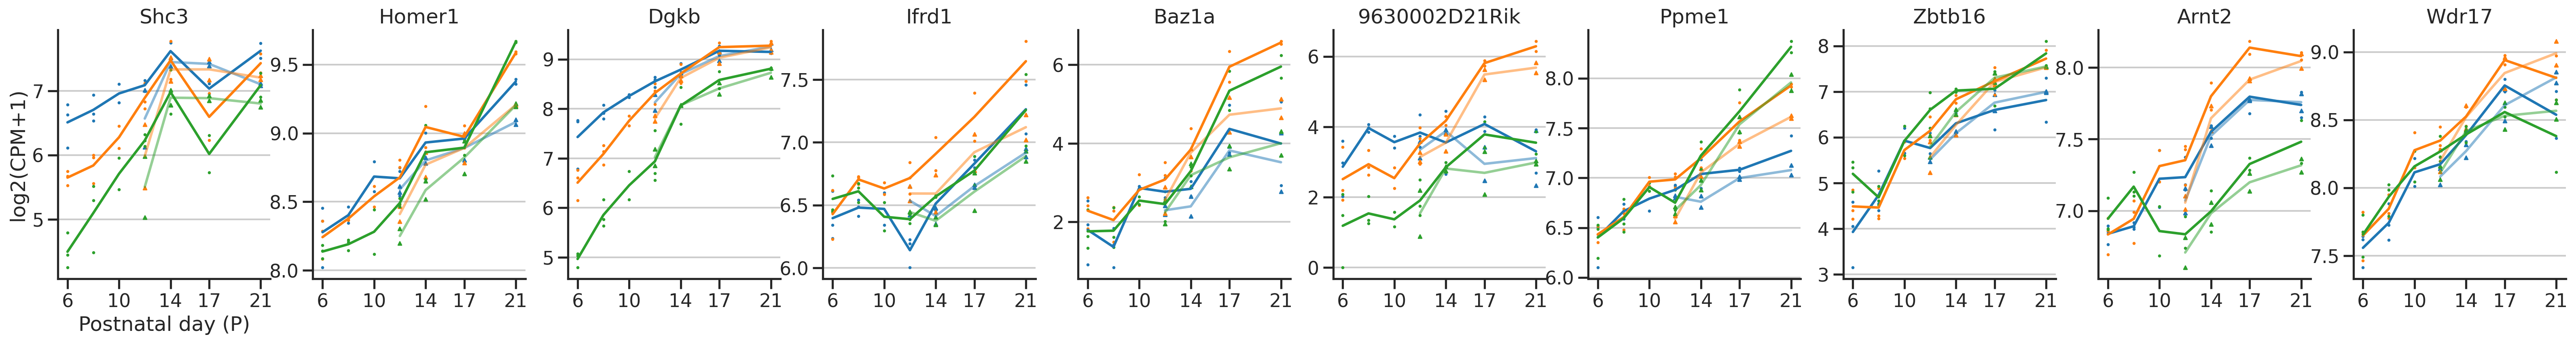

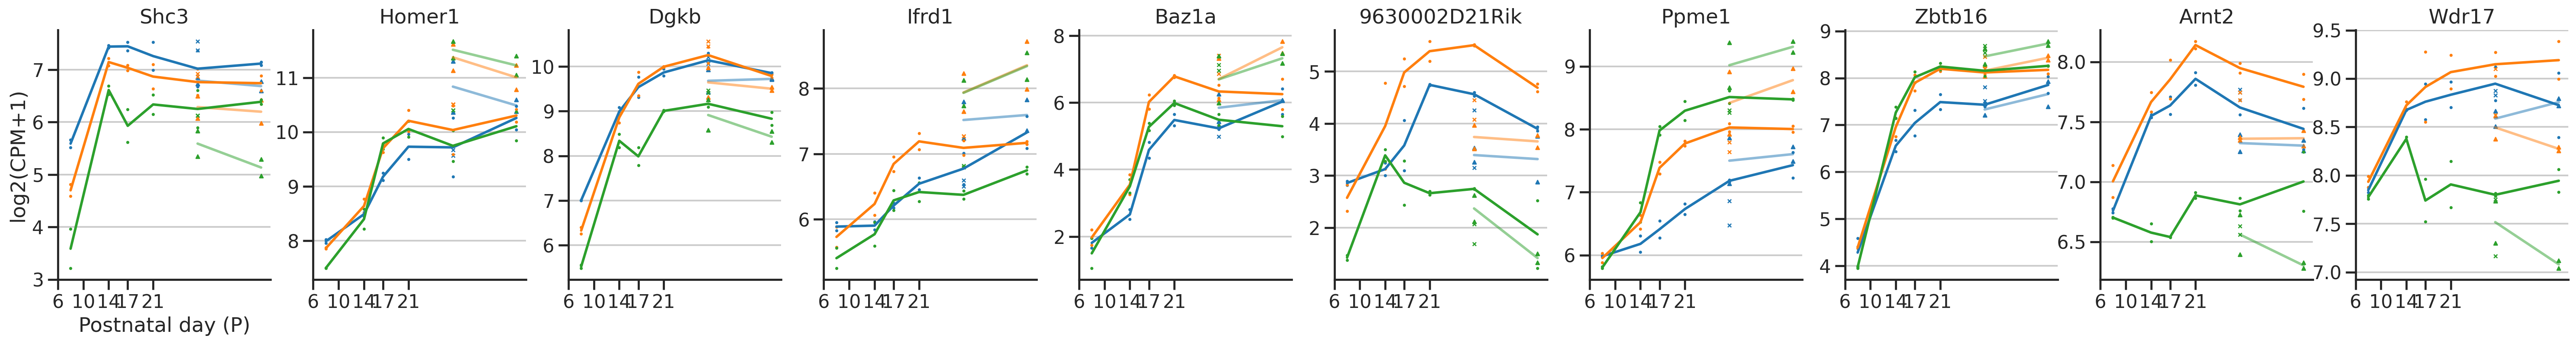

In [21]:
plot_single(bo1, genes_b5[20:],
    ['A', 'B', 'C'])
plot_single(bo0, genes_b5[20:],
    ['A', 'B', 'C'])

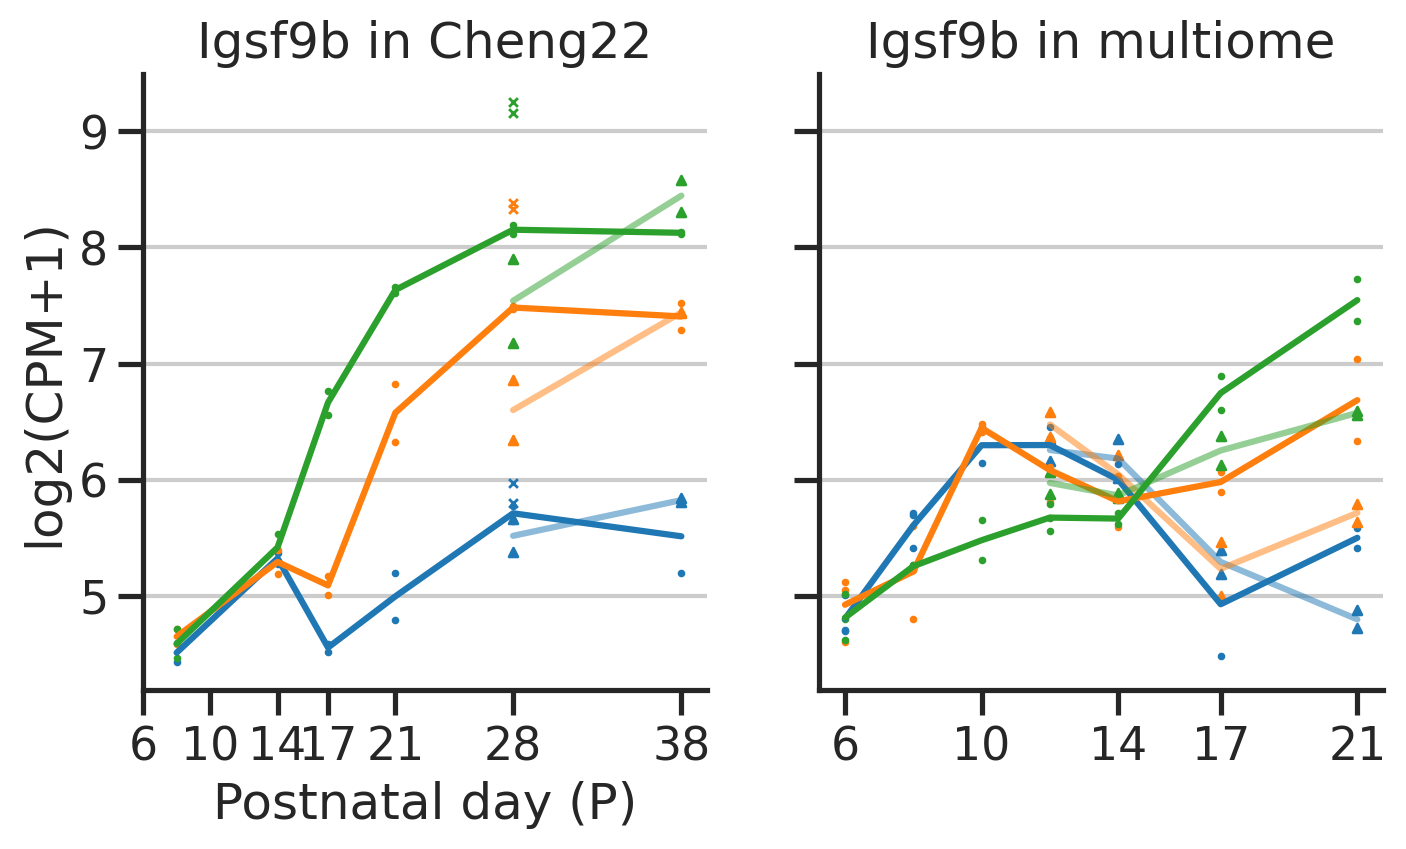

In [16]:
plot_combined_v2(bo0, bo1, 'Igsf9b', ['A', 'B', 'C'])

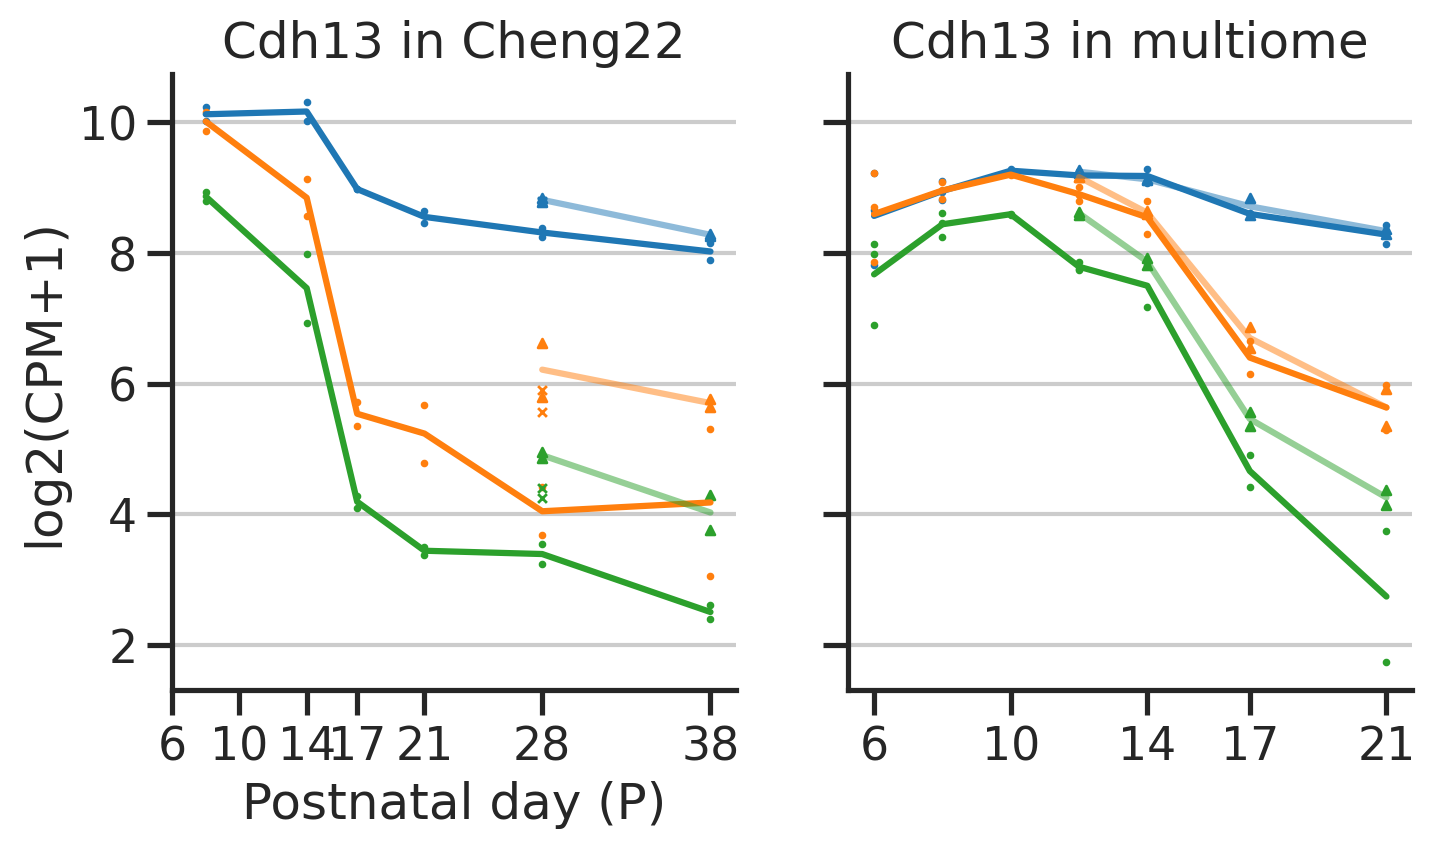

In [8]:
plot_combined_v2(bo0, bo1, 'Cdh13', ['A', 'B', 'C'])

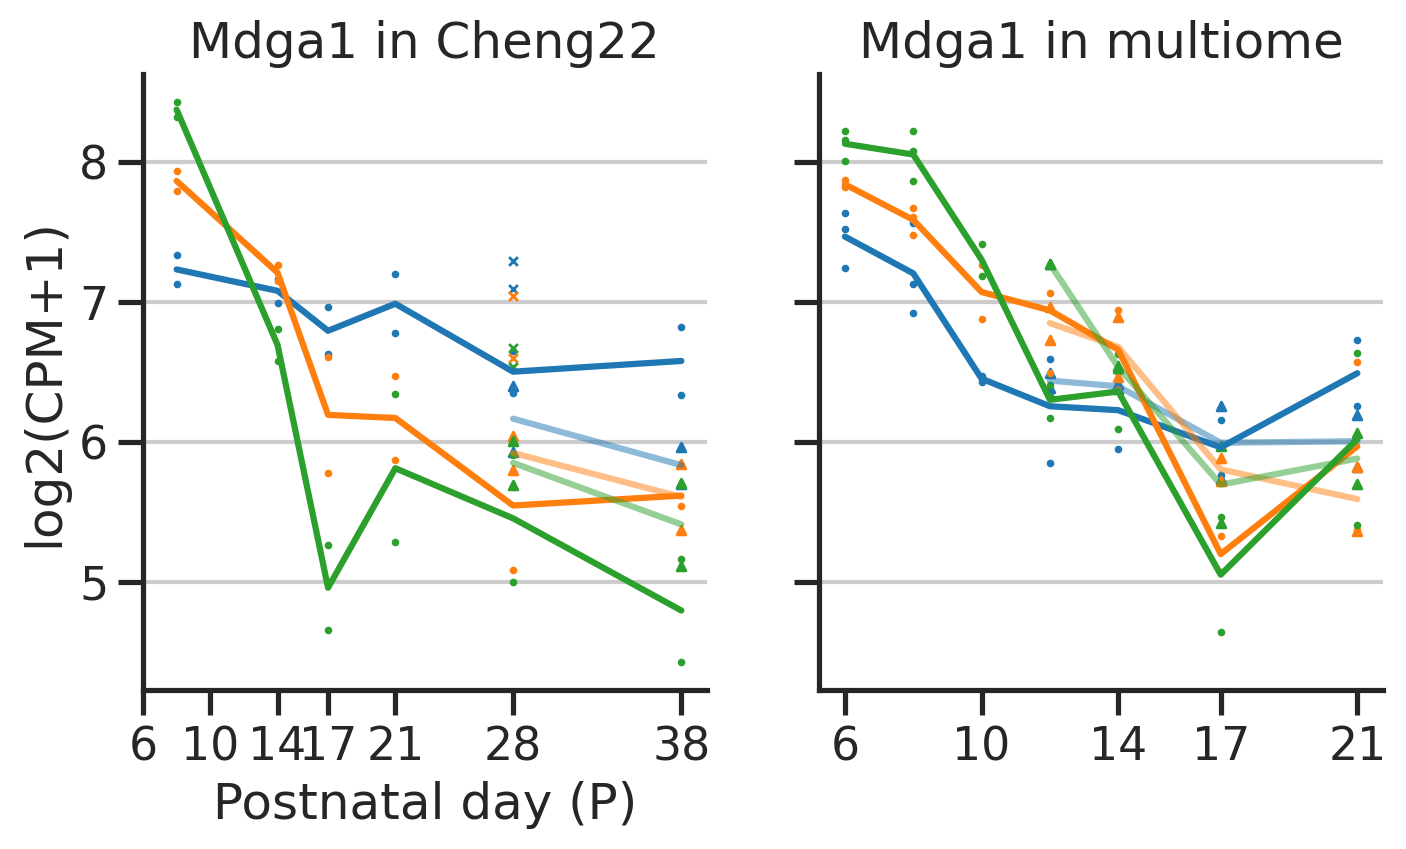

In [9]:
plot_combined_v2(bo0, bo1, 'Mdga1', ['A', 'B', 'C'])

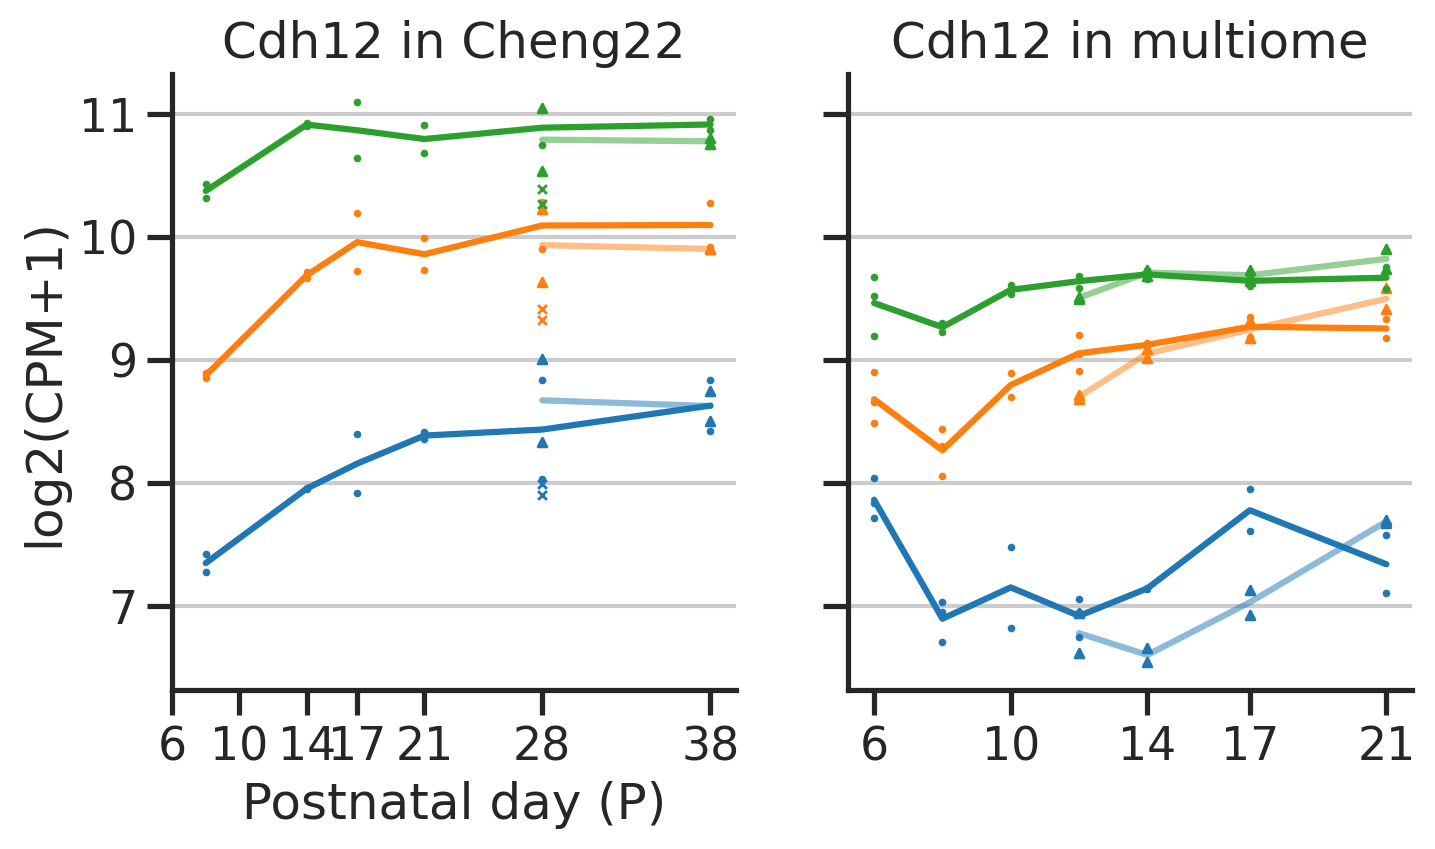

In [10]:
plot_combined_v2(bo0, bo1, 'Cdh12', ['A', 'B', 'C'])

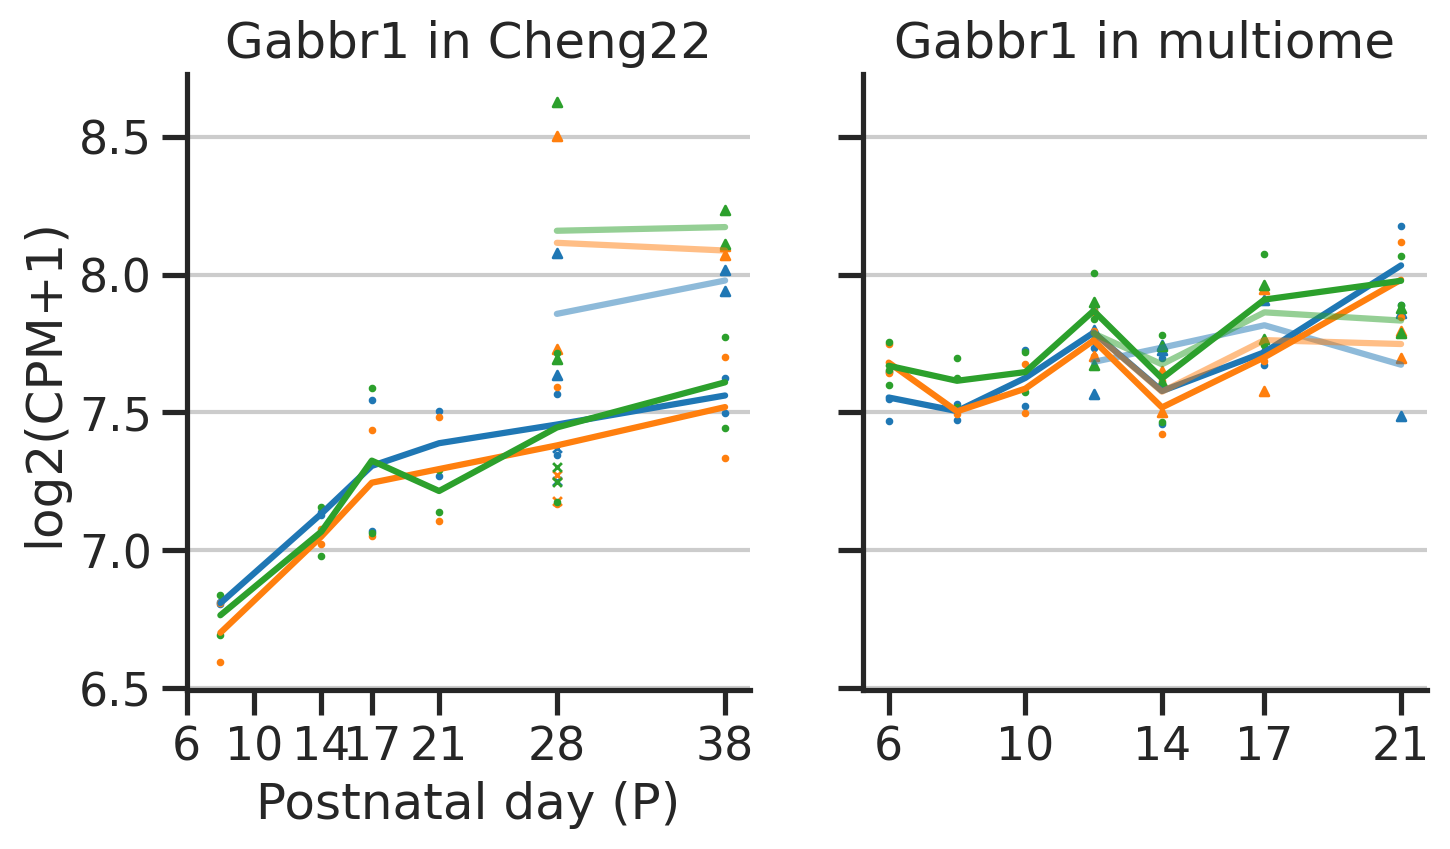

In [11]:
plot_combined_v2(bo0, bo1, 'Gabbr1', ['A', 'B', 'C'])

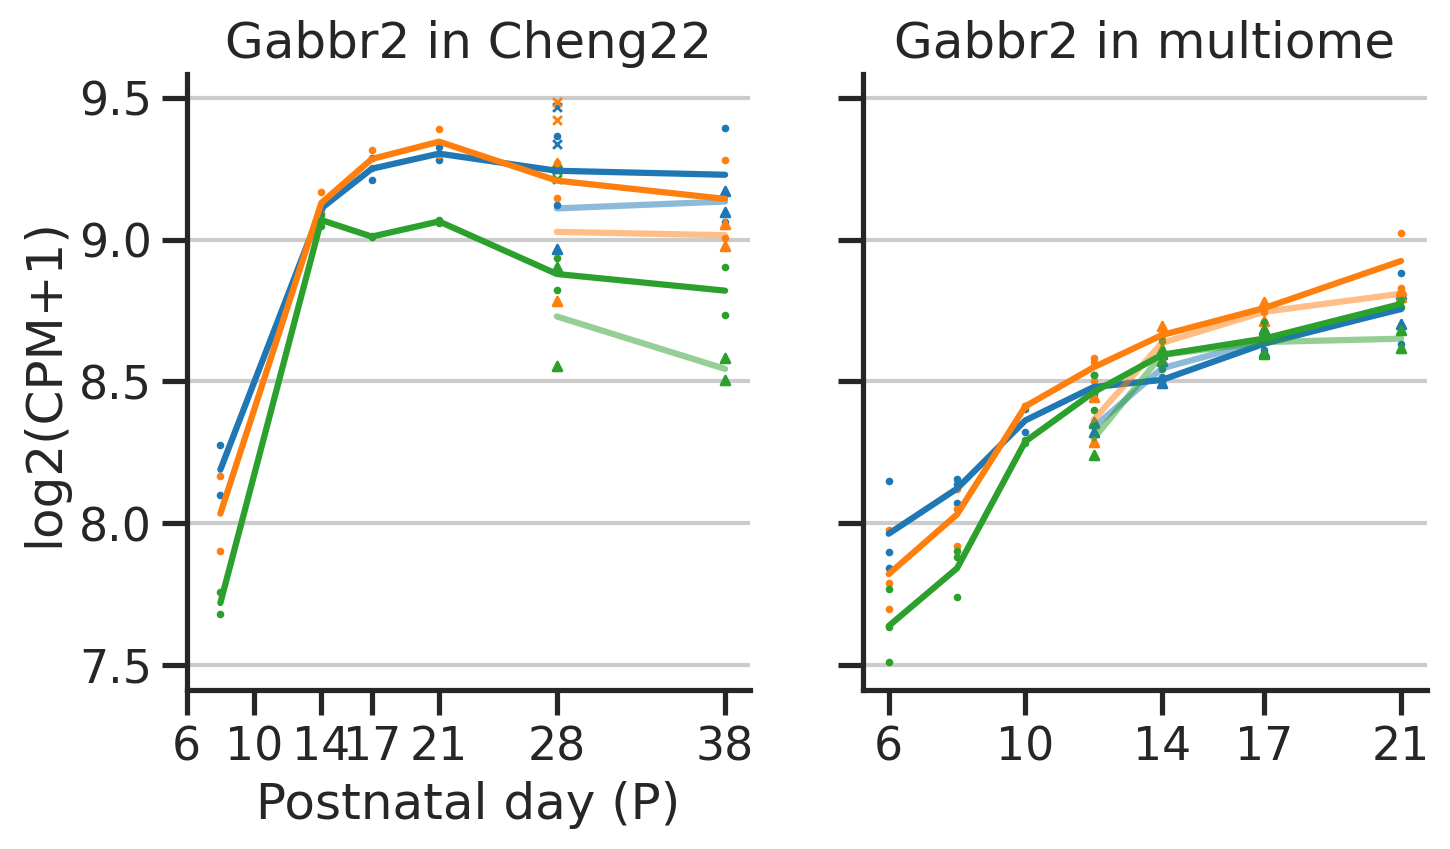

In [12]:
plot_combined_v2(bo0, bo1, 'Gabbr2', ['A', 'B', 'C'])

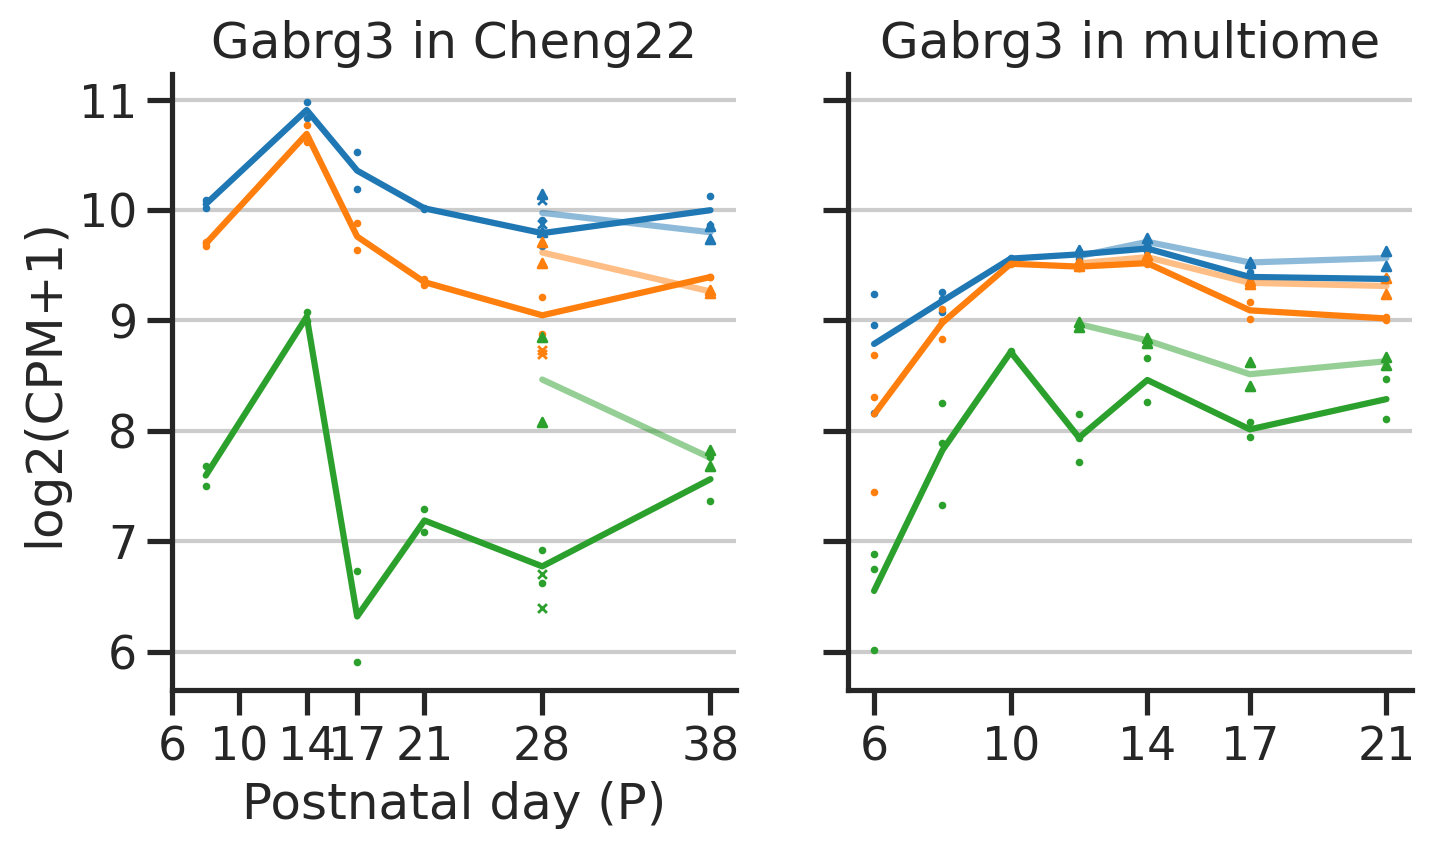

In [22]:
plot_combined_v2(bo0, bo1, 'Gabrg3', ['A', 'B', 'C'])

# GABAARs

In [17]:
selected_genes = [
    "Gabra1",
    "Gabra2",
    "Gabra3",
    "Gabra4",
    "Gabra5",
    "Gabra6",
    
    "Gabrb1",
    "Gabrb2",
    "Gabrb3",
    
    "Gabrg1",
    "Gabrg2",
    "Gabrg3",
    
    
    "Gabrd",    
    "Gabre",    
    "Gabrp",    
    "Gabrq",    
    "Gabrr1",
    "Gabrr2",
    "Gabrr3",
]
print(len(selected_genes), selected_genes)
selected_genes = np.intersect1d(selected_genes, bo0.genes)
print(len(selected_genes), selected_genes)

19 ['Gabra1', 'Gabra2', 'Gabra3', 'Gabra4', 'Gabra5', 'Gabra6', 'Gabrb1', 'Gabrb2', 'Gabrb3', 'Gabrg1', 'Gabrg2', 'Gabrg3', 'Gabrd', 'Gabre', 'Gabrp', 'Gabrq', 'Gabrr1', 'Gabrr2', 'Gabrr3']
14 ['Gabra1' 'Gabra2' 'Gabra3' 'Gabra4' 'Gabra5' 'Gabrb1' 'Gabrb2' 'Gabrb3'
 'Gabrd' 'Gabrg1' 'Gabrg2' 'Gabrg3' 'Gabrr2' 'Gabrr3']


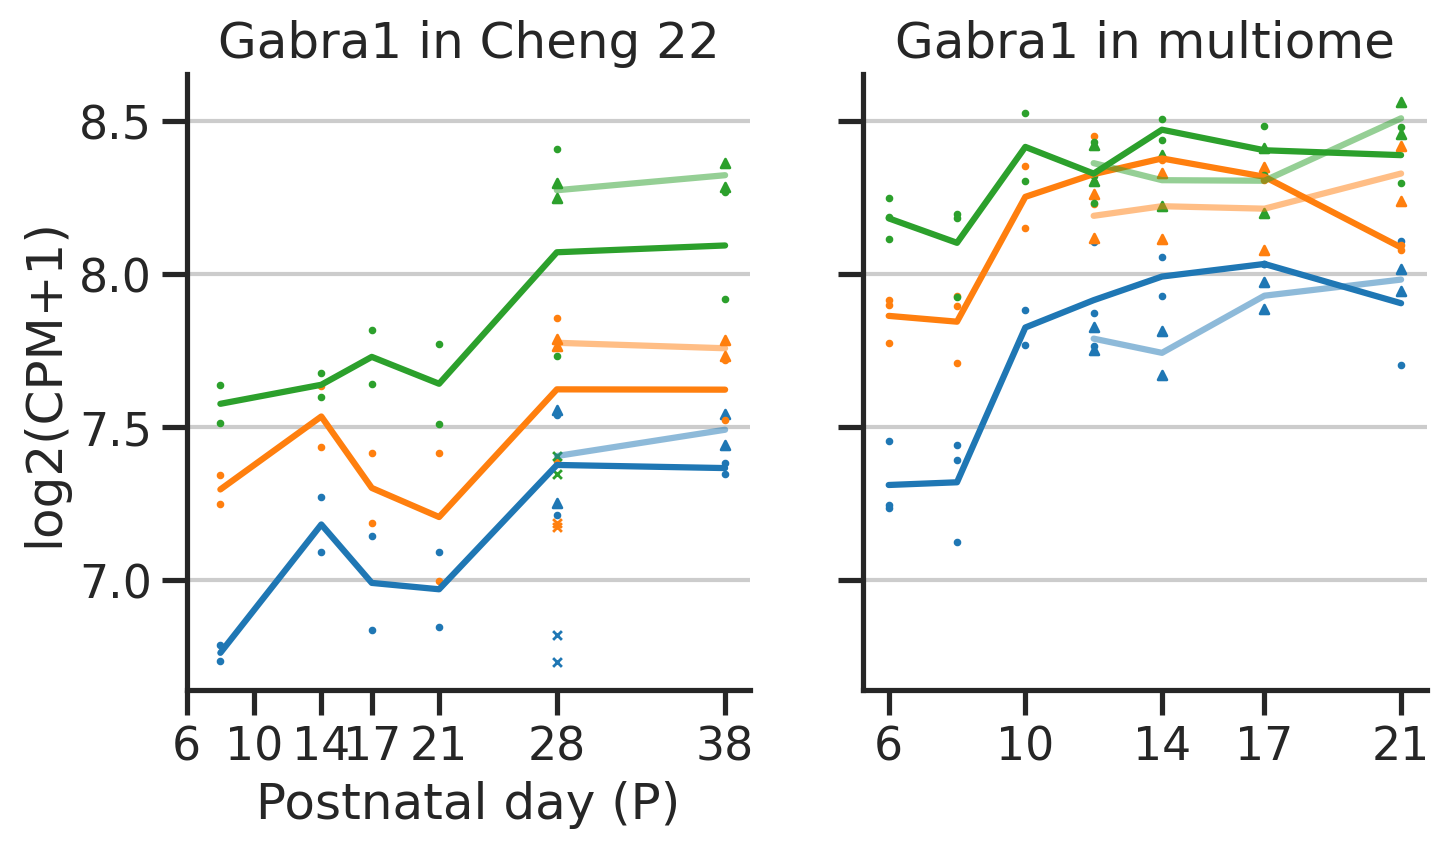

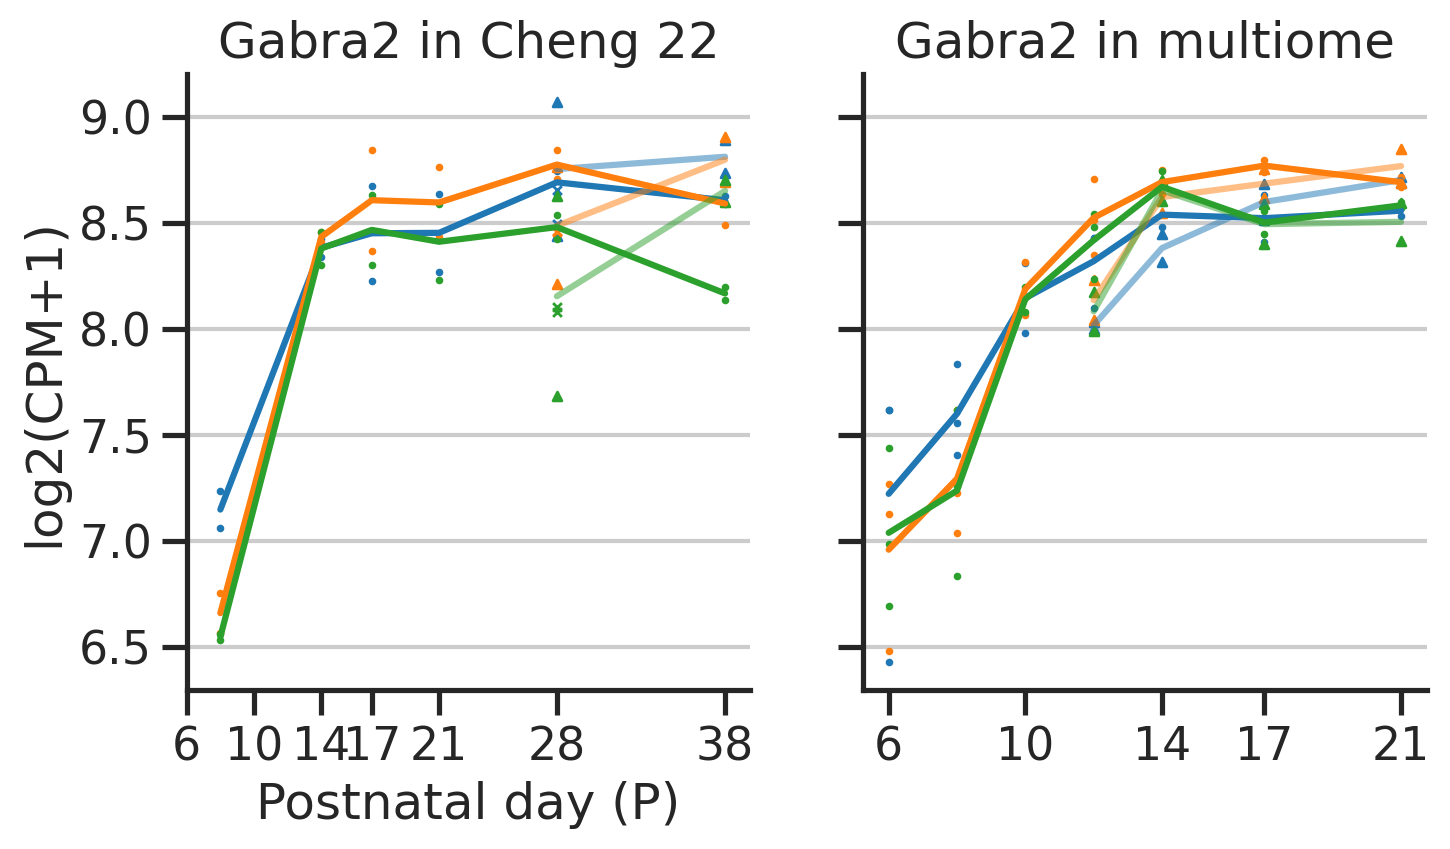

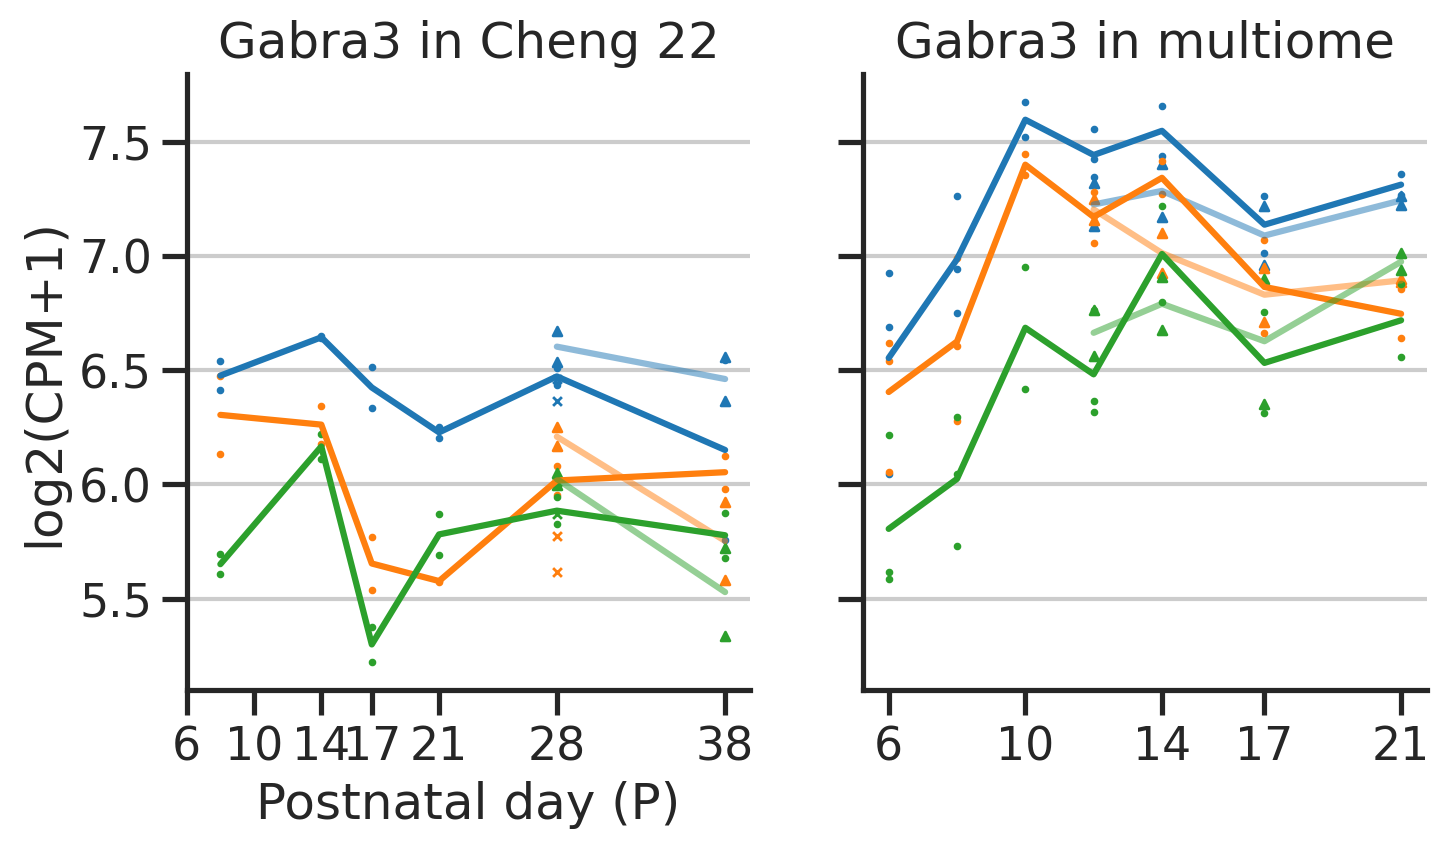

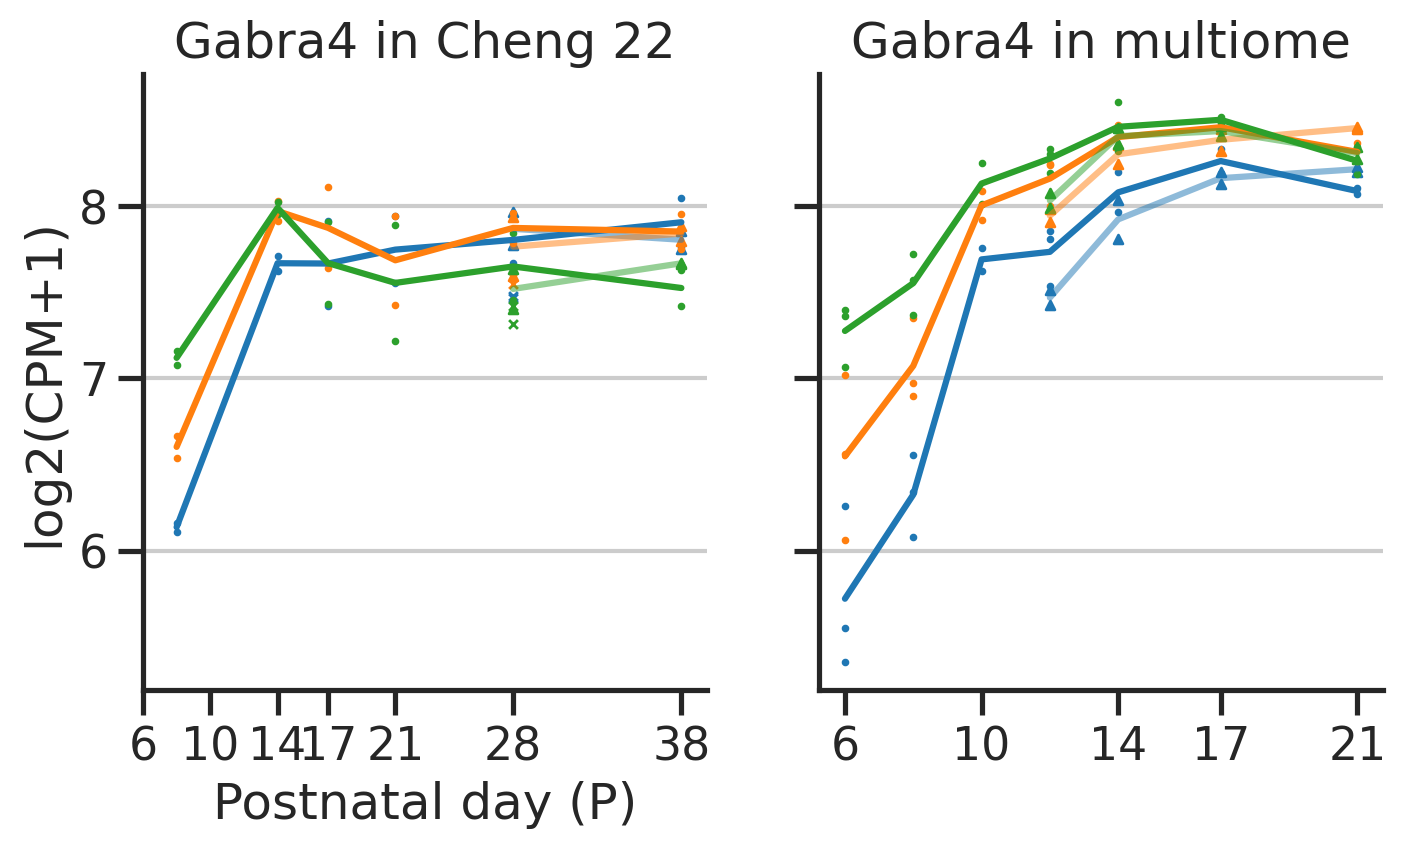

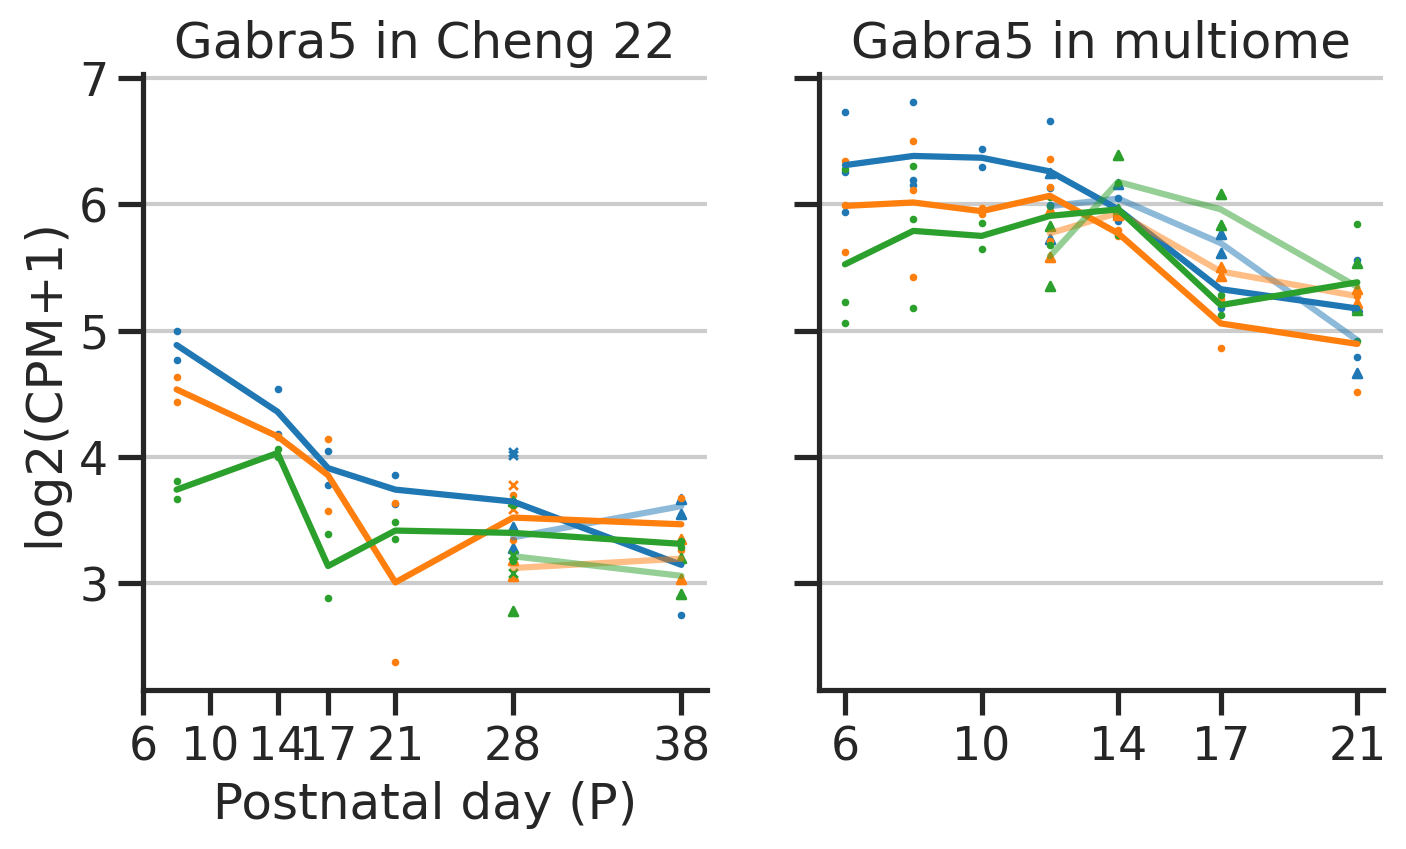

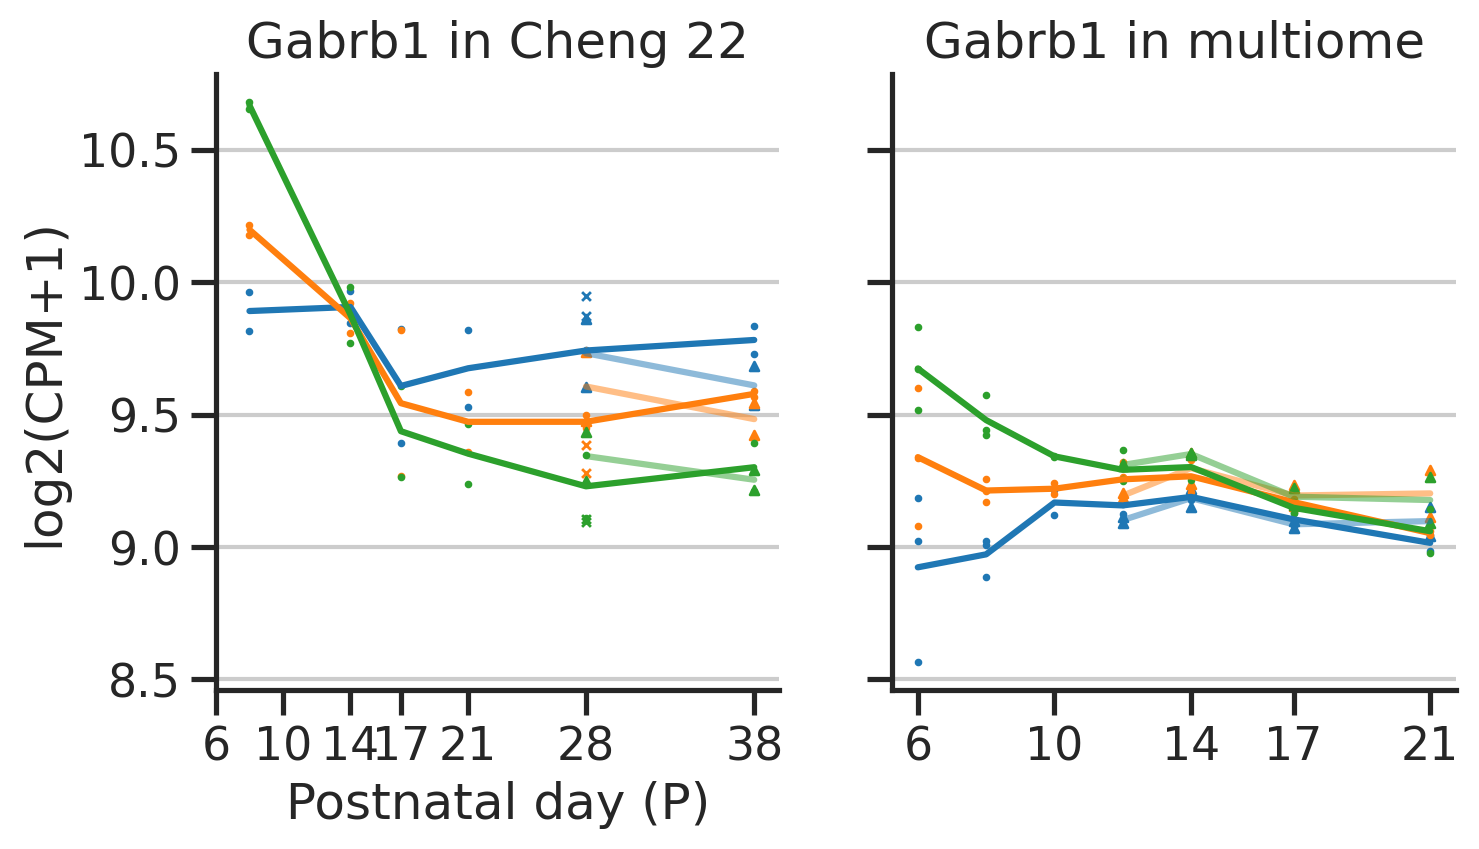

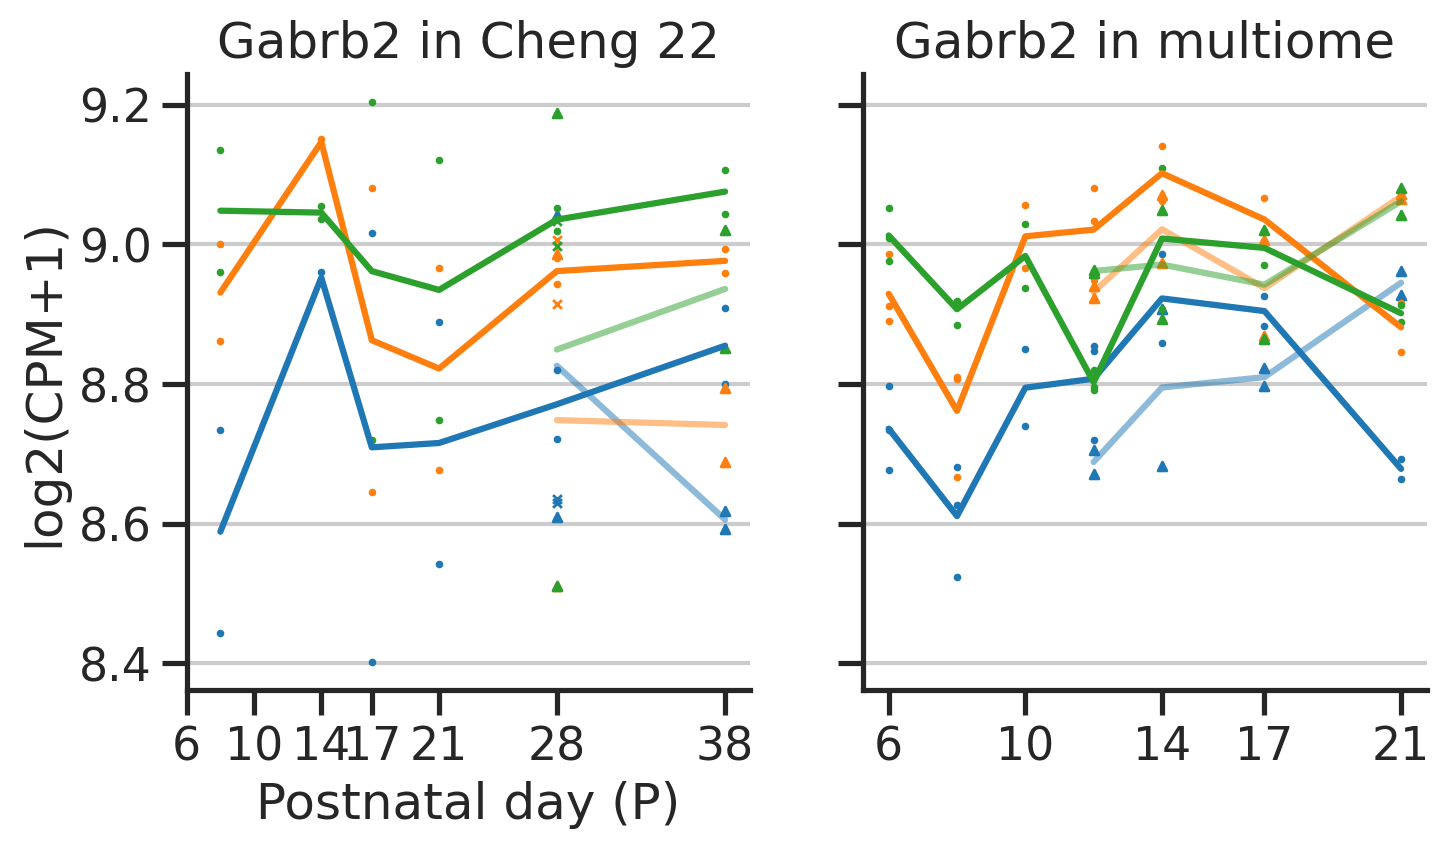

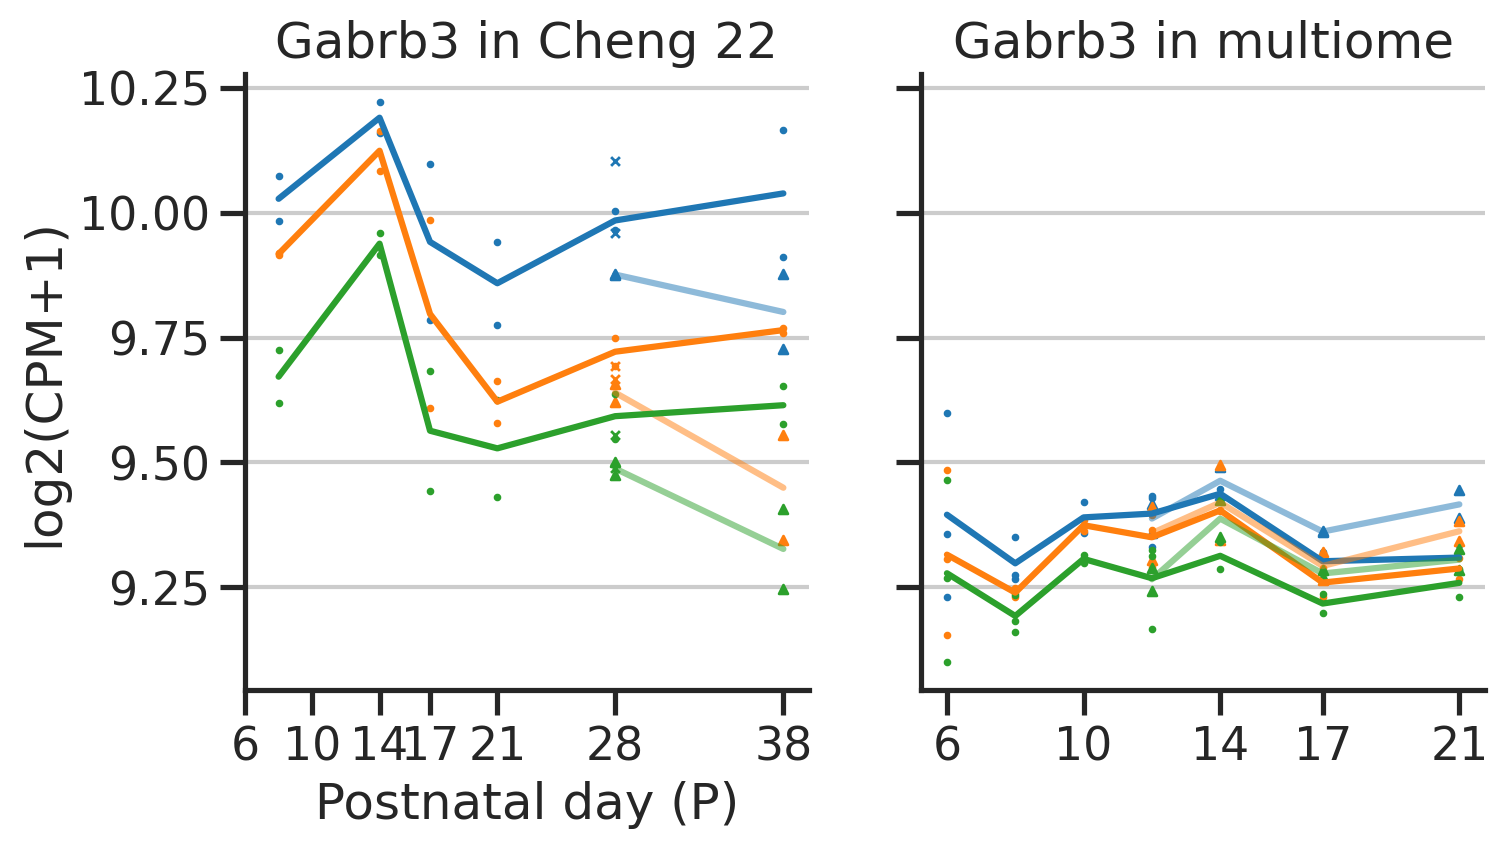

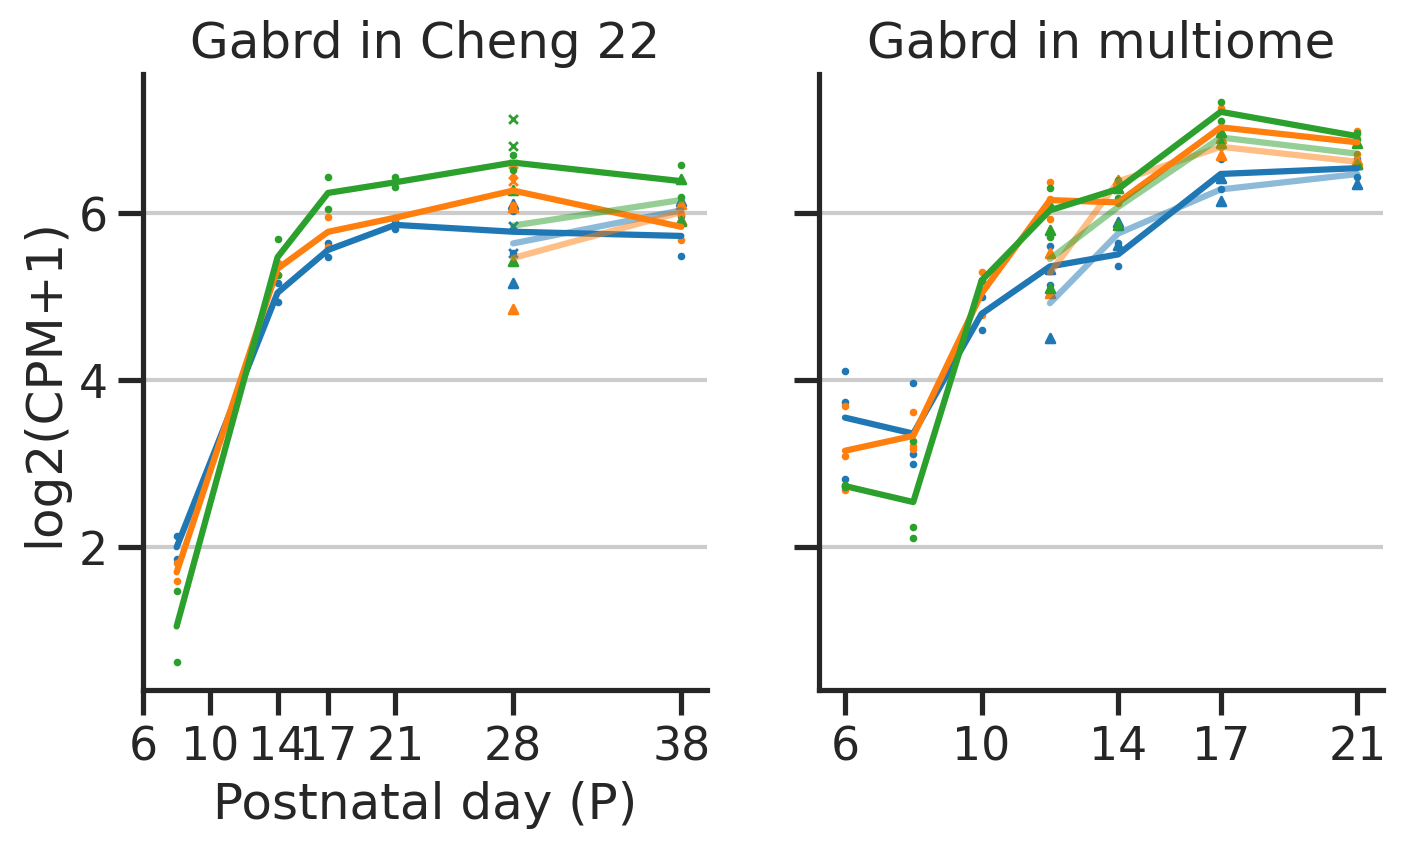

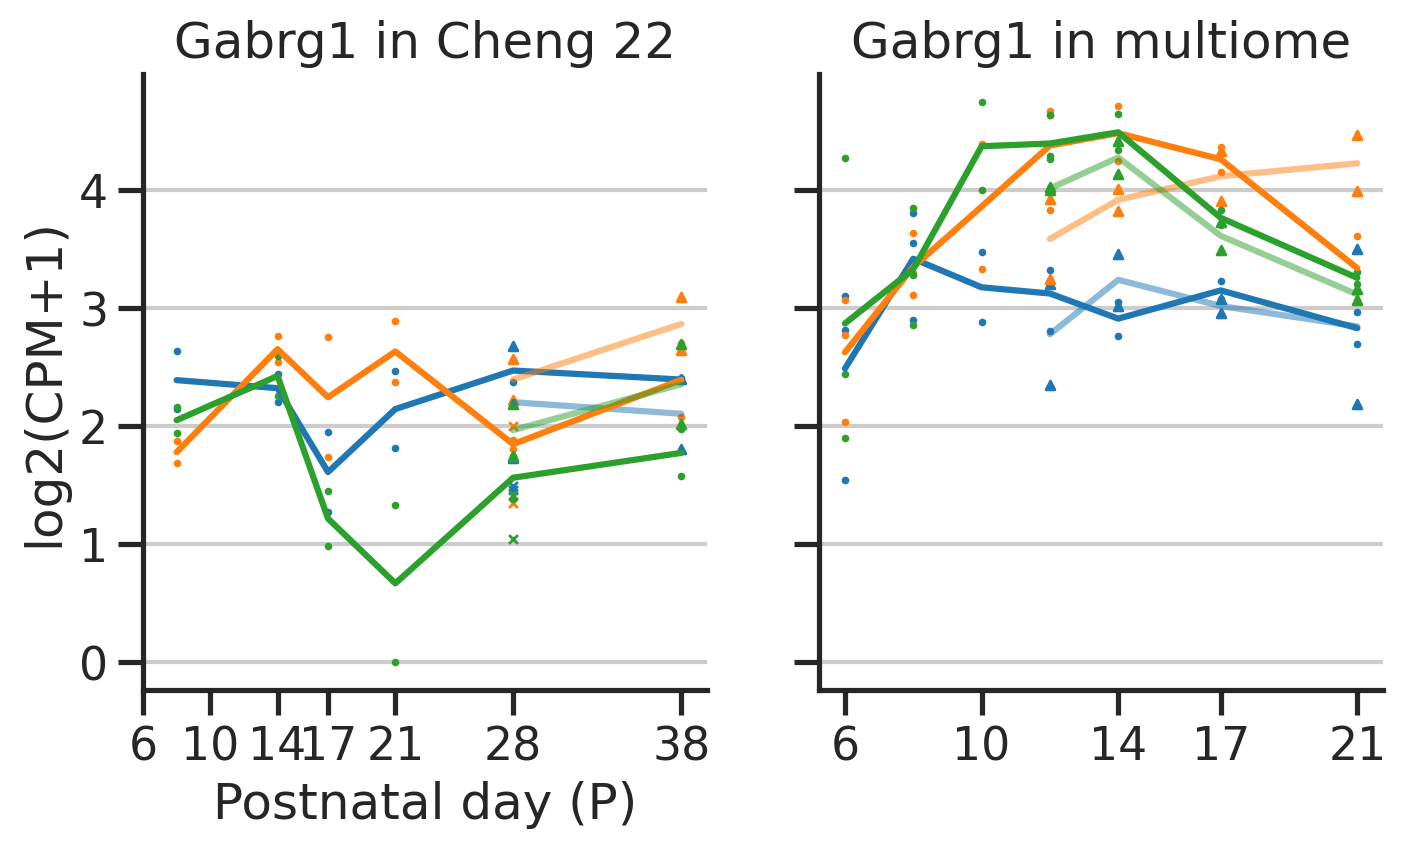

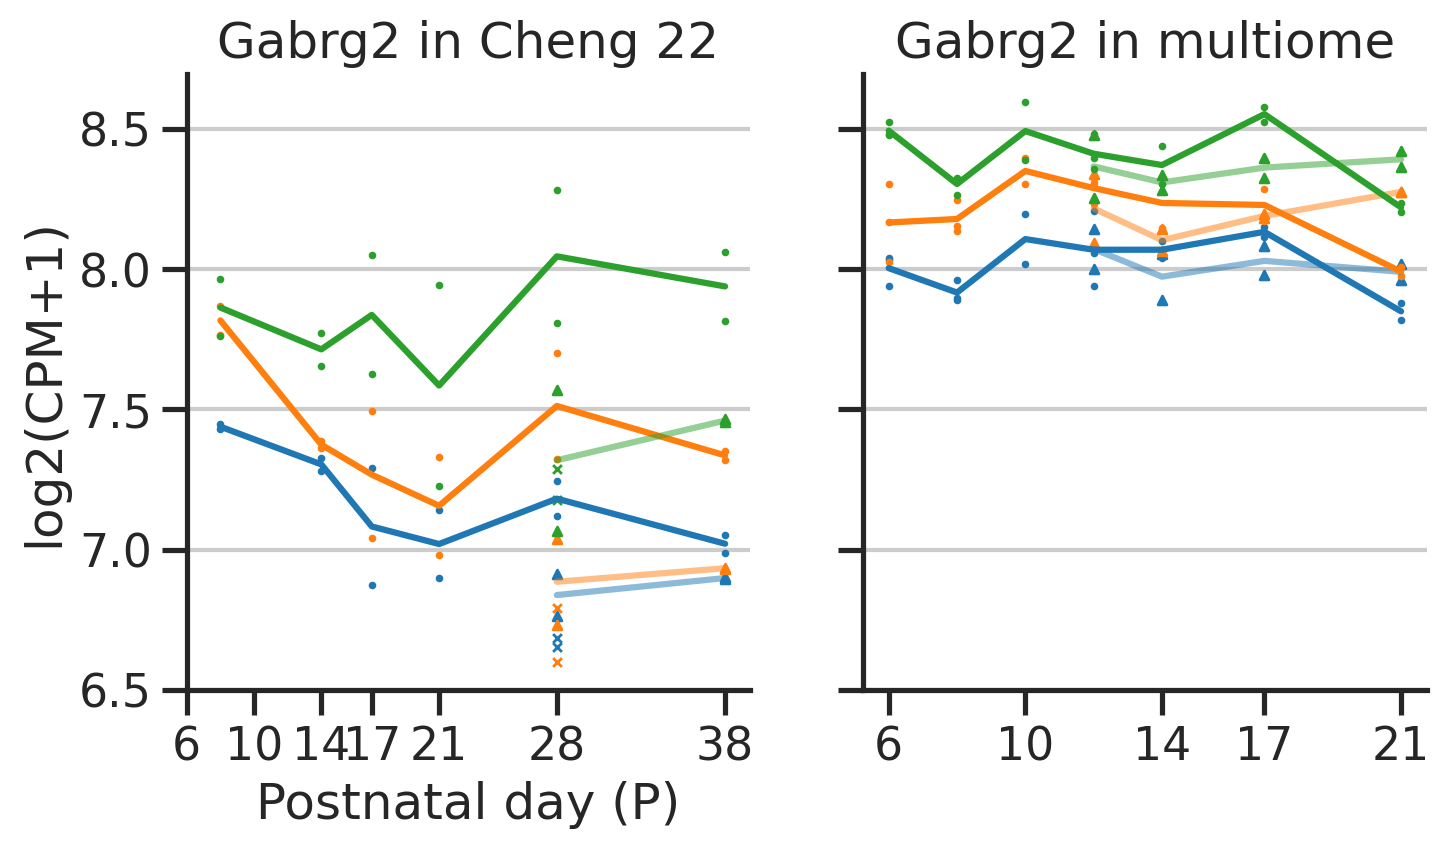

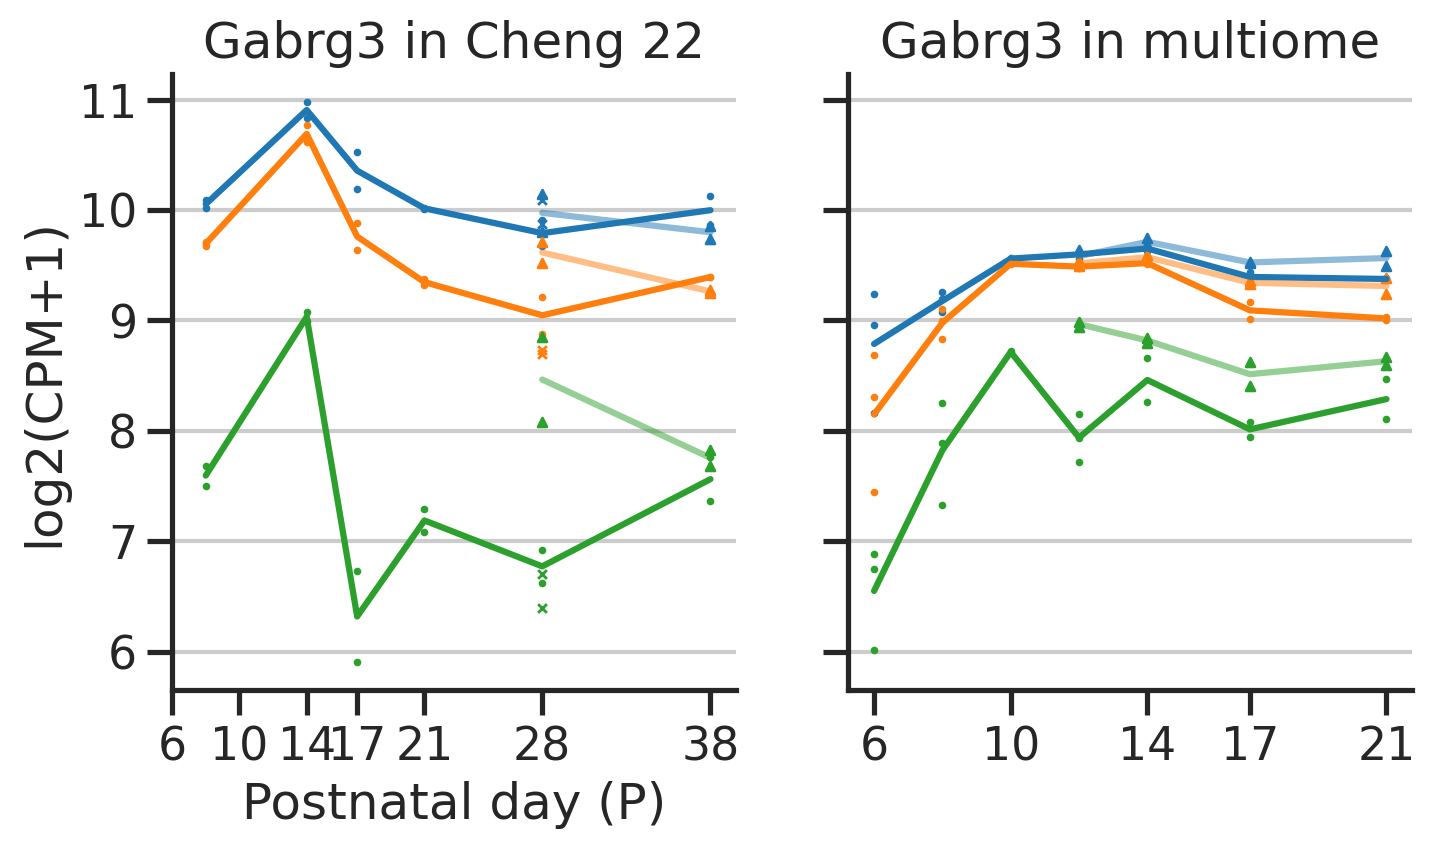

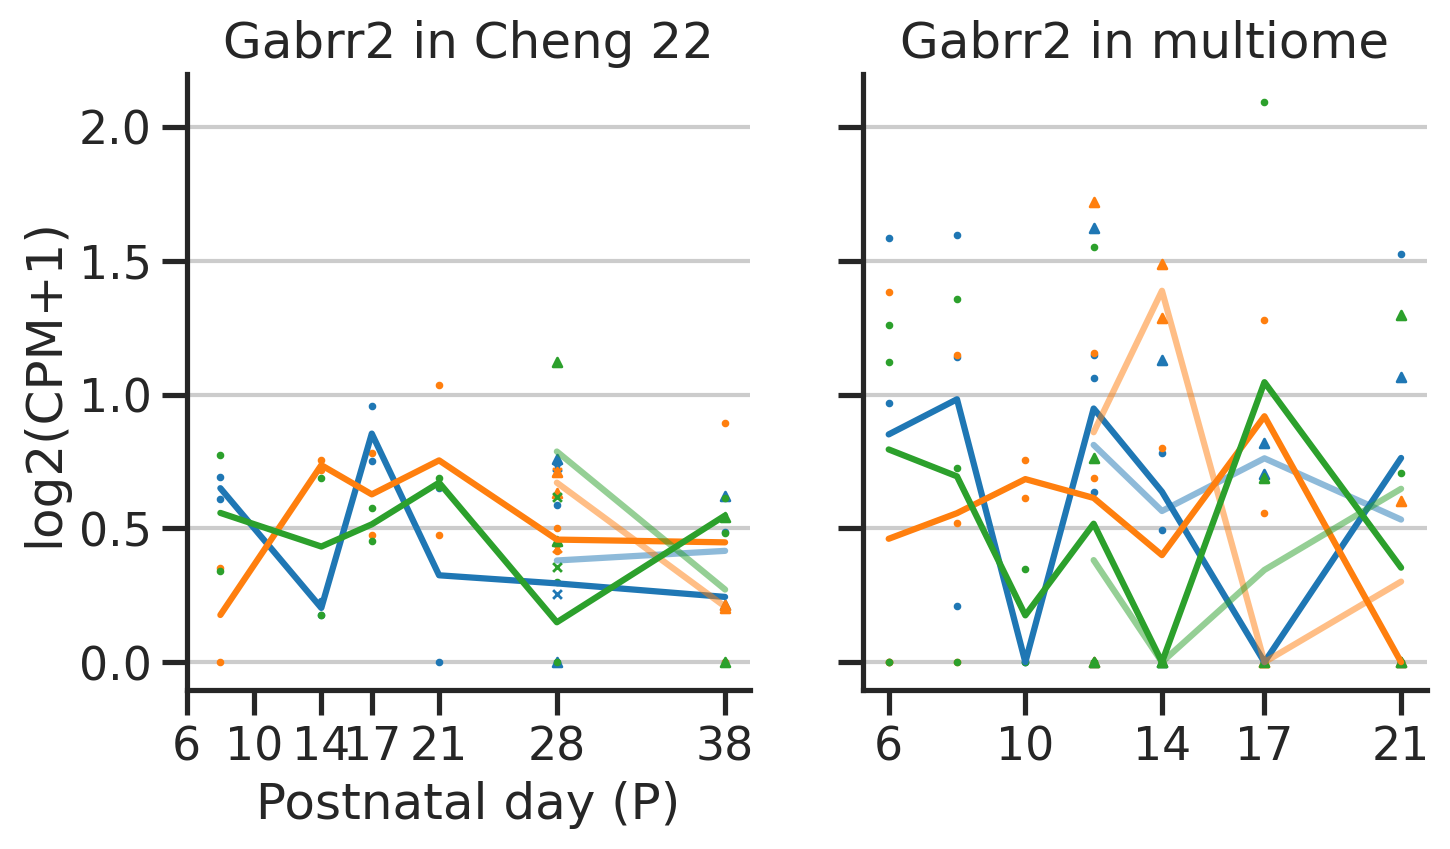

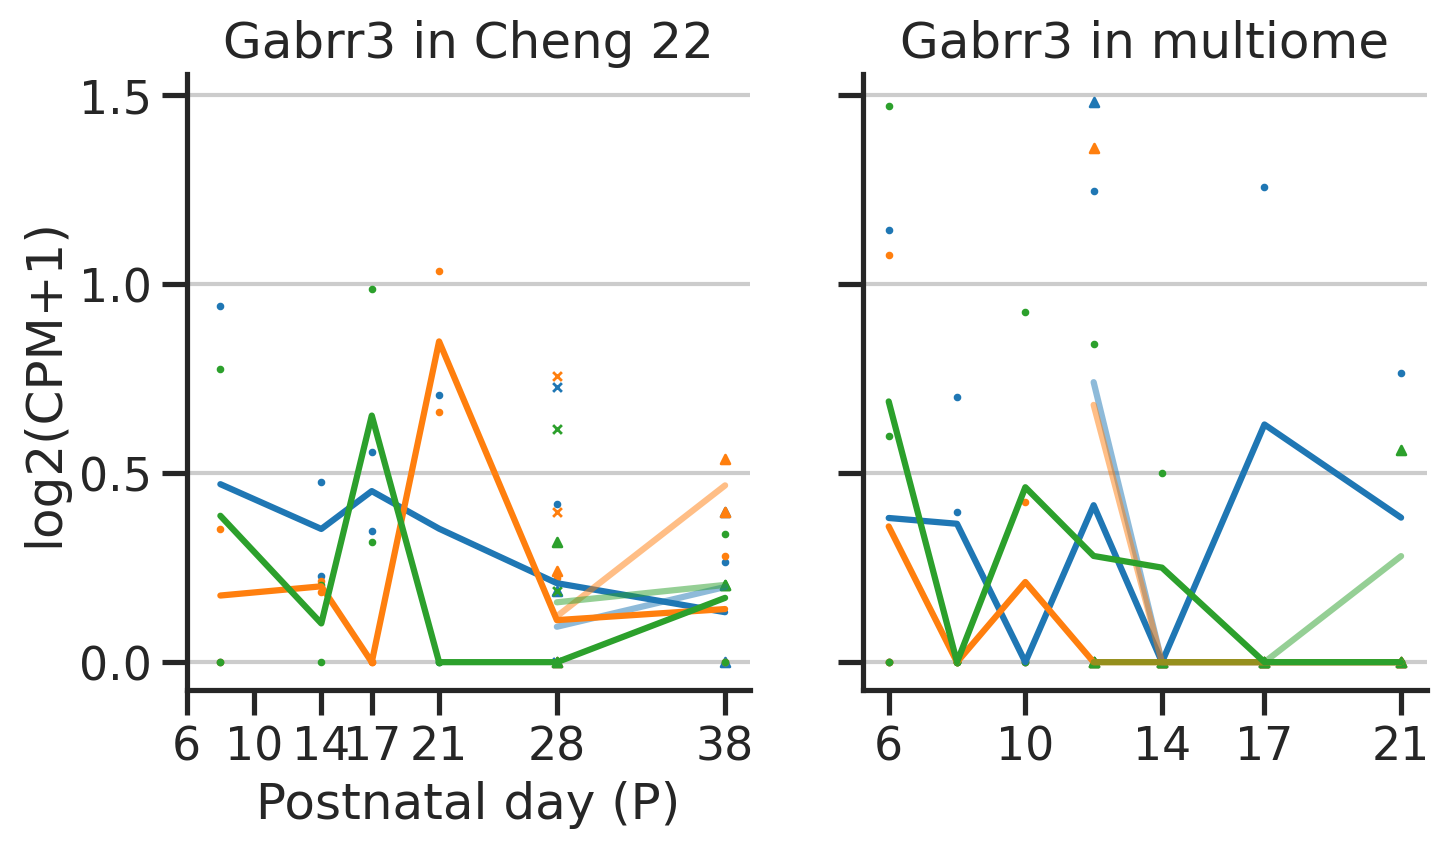

In [18]:
for gene in selected_genes:
    plot_combined_v2(bo0, bo1, gene, ['A', 'B', 'C'])